## **Problem Statement**

Submitted by : Neha Biswas

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## **Importing necessary libraries**

In [ ]:
# Importing libraries for reading the data manipulation:
import numpy as np
import pandas as pd

# Importing libraries for data visualization:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

In [ ]:
# Removes the limit for the number of displayed columns:
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows:
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [ ]:
# Importing function train_test_split to split the data into train, validation and test sets:
from sklearn.model_selection import train_test_split

In [ ]:
# Importing function to impute missing values:
from sklearn.impute import SimpleImputer

In [ ]:
# To build various models:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier

In [ ]:
# Metric Scores : to check model performance
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer
)

In [ ]:
# Importing functions to perform K-fold Validation and evaluating Cross Validation Score:
from sklearn.model_selection import StratifiedKFold, cross_val_score
# To tune different models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# To oversample and undersample data:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# To create pipelines and personalizing them:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Function Definition for different functions used**

In [ ]:
# Function to create histogram and box plots:
def creating_hist_box(df, feature, kde= True, bins=None, figsize =(10, 4)):
      f2, (ax_hist, ax_box) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
      f2.tight_layout(pad=5.0)

      if bins:
        sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist, bins=bins)
        ax_hist.set_title(f'Histogram with bins = {bins}')
      else:
        sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist)
        ax_hist.set_title(f'Histogram with default no of bins.')

      sns.boxplot(data=df, x=feature, ax=ax_box, showmeans=True, color="violet")
      ax_box.set_title('Boxplot')

In [ ]:
# Function to compute different metrics to check performance of a classification model built using sklearn:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
# Function to plot distributions wrt target:
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
# defining a function to plot the confusion_matrix of a dtree model:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## **Loading the dataset**

In [ ]:
# Loading the data:
wind_energy_df = pd.read_csv('/content/drive/MyDrive/Univ_Texas/Model_Tuning /Project/Train.csv.csv')

In [ ]:
# Loading the test data:
wind_energy_df_test = pd.read_csv('/content/drive/MyDrive/Univ_Texas/Model_Tuning /Project/Test.csv.csv')

In [ ]:
# Making a copy of the datset to prevent causing any changes in the original dataset,
# We will use the copied dataset for futher analysis:
df = wind_energy_df.copy()

In [ ]:
# Making a copy of the test datset to prevent causing any changes in the original test dataset,
# We will use the copied dataset for futher analysis:
df_test = wind_energy_df_test.copy()

## **Data Overview**

#### Data for model building

In [ ]:
# Displaying first 5 rows of the dataset:
df.head()

V1       V2       V3       V4       V5       V6       V7       V8  \
0 -4.46461 -4.67913  3.10155  0.50613 -0.22108 -2.03251 -2.91087  0.05071   
1  3.36591  3.65338  0.90967 -1.36753  0.33202  2.35894  0.73260 -4.33213   
2 -3.83184 -5.82444  0.63403 -2.41882 -1.77383  1.01682 -2.09894 -3.17320   
3  1.61810  1.88834  7.04614 -1.14728  0.08308 -1.52978  0.20731 -2.49363   
4 -0.11144  3.87249 -3.75836 -2.98290  3.79271  0.54496  0.20543  4.84899   

        V9      V10      V11      V12      V13      V14      V15      V16  \
0 -1.52235  3.76189 -5.71472  0.73589  0.98125  1.41788 -3.37582 -3.04730   
1  0.56569 -0.10108  1.91446 -0.95146 -1.25526 -2.70652  0.19322 -4.76938   
2 -2.08186  5.39262 -0.77067  1.10672  1.14426  0.94330 -3.16380 -4.24782   
3  0.34493  2.11858 -3.05302  0.45972  2.70453 -0.63609 -0.45372 -3.17405   
4 -1.85492 -6.22002  1.99835  4.72376  0.70911 -1.98943 -2.63268  4.18445   

       V17      V18      V19      V20      V21      V22      V23      V24  \
0  0.30619  2.91410  2.26998  4.39488 -2.38830  0.64639 -1.19051  3.13299   
1 -2.20532  0.90772  0.75689 -5.83368 -3.06512  1.59665 -1.75731  1.76644   
2 -4.03891  3.68853  3.31120  1.05900 -2.14303  1.65012 -1.66059  1.67991   
3 -3.40435 -1.28154  1.58210 -1.95178 -3.51656 -1.20601 -5.62785 -1.81765   
4  2.24536  3.73445 -6.31277 -5.37992 -0.88667  2.06169  9.44559  4.48998   

       V25      V26      V27      V28      V29      V30      V31      V32  \
0  0.66528 -2.51085 -0.03674  0.72622 -3.98219 -1.07264  1.66710  3.05970   
1 -0.26710  3.62504  1.50035 -0.58571  0.78303 -0.20122  0.02488 -1.79547   
2 -0.45078 -4.55069  3.73878  1.13440 -2.03353  0.84084 -1.60040 -0.25710   
3  2.12414  5.29464  4.74814 -2.30854 -3.96298 -6.02873  4.94877 -3.58443   
4 -3.94514  4.58207 -8.78042 -3.38297  5.10651  6.78751  2.04418  8.26590   

       V33       V34     V35      V36      V37      V38      V39      V40  \
0 -1.69044   2.84630 2.23520  6.66749  0.44381 -2.36917  2.95058 -3.48032   
1  3.03278  -2.46751 1.89460 -2.29778 -1.73105  5.90884 -0.38635  0.61624   
2  0.80355   4.08622 2.29214  5.36085  0.35199  2.94002  3.83916 -4.30940   
3 -2.57747   1.36377 0.62271  5.55010 -1.52680  0.13885  3.10143 -1.27738   
4  6.62921 -10.06869 1.22299 -3.22976  1.68691 -2.16390 -3.64462  6.51034   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0

In [ ]:
# Displaying the last 5 rows of the dataset:
df.tail()

V1        V2       V3       V4       V5       V6       V7  \
19995 -2.07132  -1.08828 -0.79617 -3.01172 -2.28754  2.80731  0.48143   
19996  2.89026   2.48307  5.64392  0.93705 -1.38087  0.41205 -1.59339   
19997 -3.89698  -3.94241 -0.35136 -2.41746  1.10755 -1.52762 -3.51988   
19998 -3.18732 -10.05166  5.69596 -4.37005 -5.35476 -1.87304 -3.94721   
19999 -2.68690   1.96119  6.13709  2.60013  2.65724 -4.29088 -2.34427   

            V8       V9      V10      V11      V12     V13      V14      V15  \
19995  0.10517 -0.58660 -2.89940  8.86842  1.71716 1.35784 -1.77713  0.70978   
19996 -5.76250  2.15010  0.27230 -2.09476 -1.52583 0.07157 -3.54014 -2.76201   
19997  2.05479 -0.23400 -0.35769 -3.78197  2.18004 6.11178  1.98475 -8.33000   
19998  0.67942 -2.38925  5.45676  1.58303  3.57148 9.22657  2.55359 -7.03911   
19999  0.97400 -1.02746  0.49742 -9.58907  3.17656 1.05452 -1.41588 -4.66861   

            V16      V17      V18      V19      V20      V21      V22  \
19995   4.94494 -3.10045 -1.19923 -1.08463 -0.36504  3.13117 -3.94810   
19996 -10.63221 -0.49524  1.72007  3.87160 -1.20961 -8.22207  2.12087   
19997  -1.63918 -0.91496  5.67235 -3.92420  2.13320 -4.50203  2.77718   
19998  -0.99357 -9.66494  1.15522  3.87689  3.52363 -7.01533 -0.13204   
19999  -5.40538  3.71976  2.89292  2.32859  1.45770 -6.42854  1.81823   

           V23      V24      V25      V26      V27      V28      V29      V30  \
19995 -3.57847 -8.13907 -1.93686 -1.32769 -0.40269 -1.73480  9.99646  6.95537   
19996 -5.49181  1.45234  1.45000  3.68465  1.07676 -0.38417 -0.83859 -0.74827   
19997  5.72795  1.61982 -1.69969 -0.04188 -2.92309 -2.76016 -2.25377  2.55203   
19998 -3.44618 -4.80144 -0.87573 -3.81185  5.42208 -3.73232  0.60881  5.25646   
19999  0.80590  7.78603  0.33086  5.25742 -4.86742 -0.81894 -5.66739 -2.86097   

           V31      V32      V33      V34      V35      V36      V37      V38  \
19995 -3.93849 -8.27400  5.74501  0.58901 -0.64999 -3.04317  2.21646  0.60872   
19996 -1.08855 -4.15909  1.18147 -0.74241  5.36898 -0.69303 -1.66897  3.65995   
19997  0.98186  7.11216  1.47608 -3.95371  1.85555  5.02921  2.08259 -6.40930   
19998  1.91477  0.40281  3.16366  3.75209  8.52989  8.45063  0.20396 -7.12992   
19999  4.67428  6.62081 -1.98879 -1.34890  3.95180  5.44971 -0.45541 -2.20206   

          V39      V40  Target  
19995 0.17819  2.92775       1  
19996 0.81986 -1.98727       0  
19997 1.47714 -0.87415       0  
19998 4.24939 -6.11227       0  
19999 1.67823 -1.97441       0

In [ ]:
# Checking shape of the dataset:
df.shape
print(f'No. of rows in the dataset: {df.shape[0]}')
print(f'No. of columns in the dataset: {df.shape[1]}')

No. of rows in the dataset: 20000
No. of columns in the dataset: 41


In [ ]:
# Info table: Checking the datatypes of the columns for the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [ ]:
# Checking percentage of missing values:
df.isnull().sum()/df.shape[0]

V1       0.00090
V2       0.00090
V3       0.00000
V4       0.00000
V5       0.00000
V6       0.00000
V7       0.00000
V8       0.00000
V9       0.00000
V10      0.00000
V11      0.00000
V12      0.00000
V13      0.00000
V14      0.00000
V15      0.00000
V16      0.00000
V17      0.00000
V18      0.00000
V19      0.00000
V20      0.00000
V21      0.00000
V22      0.00000
V23      0.00000
V24      0.00000
V25      0.00000
V26      0.00000
V27      0.00000
V28      0.00000
V29      0.00000
V30      0.00000
V31      0.00000
V32      0.00000
V33      0.00000
V34      0.00000
V35      0.00000
V36      0.00000
V37      0.00000
V38      0.00000
V39      0.00000
V40      0.00000
Target   0.00000
dtype: float64

In [ ]:
# Checking for duplicate rows:
df.duplicated().sum()

0

Observations:

*   The data frame has 41 columns. Each row represents data collected by the sensors fitted across different machines which give us information about its wear and tear concerning various factors such as environmental factors and also other factors related to various parts of the wind turbine.
*   There are 20000 rows and 41 columns in the dataset.
*   The columns have int, float, and object datatypes.
*   40 columns are of float datatype, while only the Target column is of int datatype.
*   The column names have been ciphered and hence the context of individual columns cannot be stated clearly.
*   Columns V1 AND V2 have 18 missing values each i.e., 0.0009% values of both these columns are missing.
*   There are no duplicate records in the dataset.

#### Data for model testing

In [ ]:
# Displaying first 5 rows of the test dataset:
df_test.head()

V1       V2       V3       V4       V5       V6       V7       V8  \
0 -0.61349 -3.81964  2.20230  1.30042 -1.18493 -4.49596 -1.83582  4.72299   
1  0.38961 -0.51234  0.52705 -2.57678 -1.01677  2.23511 -0.44130 -4.40574   
2 -0.87486 -0.64063  4.08420 -1.59045  0.52586 -1.95759 -0.69537  1.34731   
3  0.23838  1.45861  4.01453  2.53448  1.19699 -3.11733 -0.92403  0.26949   
4  5.82822  2.76826 -1.23453  2.80926 -1.64165 -1.40670  0.56864  0.96504   

        V9      V10      V11      V12      V13      V14      V15      V16  \
0  1.20614 -0.34191 -5.12287  1.01702  4.81855  3.26900 -2.98433  1.38737   
1 -0.33287  1.96679  1.79654  0.41049  0.63833 -1.38960 -1.88341 -5.01792   
2 -1.73235  0.46650 -4.92821  3.56507 -0.44933 -0.65625 -0.16654 -1.63021   
3  1.32244  0.70234 -5.57835 -0.85066  2.59053  0.76742 -2.39081 -2.34196   
4  1.91838 -2.77486 -0.53002  1.37454 -0.65094 -1.67947 -0.37922 -4.44314   

       V17      V18      V19      V20      V21     V22      V23      V24  \
0  2.03200 -0.51159 -1.02307  7.33873 -2.24224 0.15549  2.05379 -2.77227   
1 -3.82724  2.41806  1.76228 -3.24230 -3.19296 1.85745 -1.70795  0.63344   
2  2.29187  2.39649  0.60128  1.79353 -2.12024 0.48197 -0.84071  1.79020   
3  0.57187 -0.93375  0.50868  1.21071 -3.25952 0.10459 -0.65887  1.49811   
4  3.89386 -0.60764  2.94493  0.36723 -5.78908 4.59753  4.45026  3.22494   

       V25      V26      V27      V28      V29      V30      V31      V32  \
0  1.85137 -1.78870 -0.27728 -1.25514 -3.83289 -1.50454  1.58677  2.29120   
1 -0.58790  0.08368  3.01394 -0.18231  0.22392  0.86523 -1.78216 -2.47494   
2  1.87439  0.36393 -0.16906 -0.48383 -2.11898 -2.15659  2.90729 -1.31889   
3  1.10030  4.14299 -0.24845 -1.13652 -5.35581 -4.54593  3.80867  3.51792   
4  0.39670  0.24776 -2.36205  1.07938 -0.47308  2.24281 -3.59142  1.77384   

       V33      V34     V35      V36      V37       V38      V39      V40  \
0 -5.41139  0.87007 0.57448  4.15719  1.42809 -10.51134  0.45466 -1.44836   
1  2.49358  0.31517 2.05929  0.68386 -0.48545   5.12835  1.72074 -1.48824   
2 -2.99746  0.45966 0.61977  5.63150  1.32351  -1.75215  1.80830  1.67575   
3 -3.07409 -0.28422 0.95458  3.02933 -1.36720  -3.41214  0.90600 -2.45089   
4 -1.50157 -2.22670 4.77683 -6.55970 -0.80555  -0.27601 -3.85821 -0.53769   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0

In [ ]:
# Displaying the last 5 rows of the test dataset:
df_test.tail()

V1       V2       V3       V4       V5       V6       V7       V8  \
4995 -5.12045  1.63480  1.25126  4.03594  3.29120 -2.93223 -1.32866  1.75407   
4996 -5.17250  1.17165  1.57911  1.21992  2.52963 -0.66865 -2.61832 -2.00055   
4997 -1.11414 -0.40358 -1.76487 -5.87947  3.57156  3.71080 -2.48295 -0.30761   
4998 -1.70324  0.61465  6.22050 -0.10413  0.95592 -3.27871 -1.63386 -0.10394   
4999 -0.60370  0.95955 -0.72100  8.22957 -1.81561 -2.27555 -2.57452 -1.04148   

           V9      V10      V11      V12      V13      V14      V15      V16  \
4995 -2.98459  1.24863 -6.87775  3.71516 -2.51181 -1.39497 -2.55414 -2.19737   
4996  0.63379 -0.57894 -3.67125  0.46018  3.32058 -1.07496 -7.11253 -4.35595   
4997 -0.92195 -2.99914 -0.11166 -1.97692 -1.62299 -0.94545 -2.73509 -0.81301   
4998  1.38815 -1.06562 -7.96981  2.26213  3.13401 -0.48575 -3.49829 -4.56171   
4999  4.12965 -2.73129 -3.29237 -1.67375  0.46451 -1.64593 -5.26341 -7.98762   

          V17     V18      V19      V20      V21      V22      V23      V24  \
4995  4.77171 2.40294  3.79176  0.48677 -2.02808  1.77792  3.66799 11.37488   
4996 -0.00109 3.69844 -0.84639 -0.22227 -3.64496  0.73604  0.92566  3.27768   
4997  0.60975 8.14884 -9.19917 -3.87248 -0.29570  1.46838  2.88432  2.79211   
4998  3.13578 2.53640 -0.79222  4.39844 -4.07302 -0.03757 -2.37125 -1.54198   
4999  6.48049 0.22633  4.96334  6.75201 -6.30577  3.27054  1.89723  3.27081   

          V25      V26      V27      V28      V29      V30      V31      V32  \
4995 -1.97709  2.25159 -7.31851  1.90696 -3.73370 -0.01245  2.12049  9.97912   
4996 -2.27676  4.45763 -4.54289 -1.34801 -1.77943  0.35220 -0.21429  4.42390   
4997 -1.13570  1.19792 -4.34168 -2.86940  4.12407  4.19673  3.47072  3.79178   
4998  2.90789  3.21451 -0.16867 -1.54133 -4.72439 -5.52504  1.66797 -4.10035   
4999 -0.63708 -0.92500 -6.75892  2.99018 -0.81384  3.49899 -8.43472  2.36978   

          V33       V34      V35      V36      V37      V38      V39      V40  \
4995  0.06344   0.21728  3.03639  2.10932 -0.55743  1.93872  0.51267 -2.69419   
4996  2.60381  -2.15217  0.91740  2.15659  0.46696  0.47012  2.19676 -2.37652   
4997  7.48151 -10.06140 -0.38717  1.84851  1.81825 -1.24563 -1.26088  7.47468   
4998 -5.94933   0.55037 -1.57364  6.82394  2.13931 -4.03616  3.43605  0.57925   
4999 -1.06241   0.79077  4.95195 -7.44083 -0.06951 -0.91808 -2.29115 -5.36289   

      Target  
4995       0  
4996       0  
4997       0  
4998       0  
4999       0

In [ ]:
# Checking shape of the test dataset:
df_test.shape
print(f'No. of rows in the dataset: {df_test.shape[0]}')
print(f'No. of columns in the dataset: {df_test.shape[1]}')

No. of rows in the dataset: 5000
No. of columns in the dataset: 41


In [ ]:
# Info table: Checking the datatypes of the columns for the test dataset:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [ ]:
# Checking percentage of missing values:
df_test.isnull().sum()/df_test.shape[0]

V1       0.00100
V2       0.00120
V3       0.00000
V4       0.00000
V5       0.00000
V6       0.00000
V7       0.00000
V8       0.00000
V9       0.00000
V10      0.00000
V11      0.00000
V12      0.00000
V13      0.00000
V14      0.00000
V15      0.00000
V16      0.00000
V17      0.00000
V18      0.00000
V19      0.00000
V20      0.00000
V21      0.00000
V22      0.00000
V23      0.00000
V24      0.00000
V25      0.00000
V26      0.00000
V27      0.00000
V28      0.00000
V29      0.00000
V30      0.00000
V31      0.00000
V32      0.00000
V33      0.00000
V34      0.00000
V35      0.00000
V36      0.00000
V37      0.00000
V38      0.00000
V39      0.00000
V40      0.00000
Target   0.00000
dtype: float64

In [ ]:
# Checking for duplicate rows:
df_test.duplicated().sum()

0

Observations:

*   The test data frame also has 41 columns.
*   There are 5000 rows and 41 columns in the test dataset.
*   The columns have int or float datatypes.
*   40 columns are of float datatype, while only the Target column is of int datatype.
*   The column names have been ciphered.
*   Column V1 has 5 (ie 0.001%) missing values.
*   Column V2 has 6 (ie 0.0012%) missing values.
*   There are no duplicate records in the test dataset.

## **Exploratory Data Analysis (EDA)**

### Statistical Summary of the data

In [ ]:
# Statistical summary of the dataset:
df.describe().T

count     mean     std       min      25%      50%      75%  \
V1     19982.00000 -0.27200 3.44162 -11.87645 -2.73715 -0.74792  1.84011   
V2     19982.00000  0.44043 3.15078 -12.31995 -1.64067  0.47154  2.54397   
V3     20000.00000  2.48470 3.38896 -10.70814  0.20686  2.25579  4.56616   
V4     20000.00000 -0.08315 3.43160 -15.08205 -2.34766 -0.13524  2.13061   
V5     20000.00000 -0.05375 2.10480  -8.60336 -1.53561 -0.10195  1.34048   
V6     20000.00000 -0.99544 2.04097 -10.22715 -2.34724 -1.00051  0.38033   
V7     20000.00000 -0.87932 1.76163  -7.94968 -2.03093 -0.91718  0.22369   
V8     20000.00000 -0.54820 3.29576 -15.65756 -2.64266 -0.38908  1.72297   
V9     20000.00000 -0.01681 2.16057  -8.59631 -1.49497 -0.06760  1.40920   
V10    20000.00000 -0.01300 2.19320  -9.85396 -1.41121  0.10097  1.47705   
V11    20000.00000 -1.89539 3.12432 -14.83206 -3.92240 -1.92124  0.11891   
V12    20000.00000  1.60483 2.93045 -12.94801 -0.39651  1.50784  3.57145   
V13    20000.00000  1.58049 2.87466 -13.22825 -0.22355  1.63719  3.45989   
V14    20000.00000 -0.95063 1.78965  -7.73859 -2.17074 -0.95716  0.27068   
V15    20000.00000 -2.41499 3.35497 -16.41661 -4.41532 -2.38262 -0.35905   
V16    20000.00000 -2.92522 4.22172 -20.37416 -5.63424 -2.68271 -0.09505   
V17    20000.00000 -0.13426 3.34546 -14.09118 -2.21561 -0.01458  2.06875   
V18    20000.00000  1.18935 2.59228 -11.64399 -0.40392  0.88340  2.57177   
V19    20000.00000  1.18181 3.39693 -13.49178 -1.05017  1.27906  3.49330   
V20    20000.00000  0.02361 3.66948 -13.92266 -2.43295  0.03342  2.51237   
V21    20000.00000 -3.61125 3.56769 -17.95623 -5.93036 -3.53289 -1.26588   
V22    20000.00000  0.95184 1.65155 -10.12209 -0.11813  0.97469  2.02559   
V23    20000.00000 -0.36612 4.03186 -14.86613 -3.09876 -0.26209  2.45175   
V24    20000.00000  1.13439 3.91207 -16.38715 -1.46806  0.96905  3.54598   
V25    20000.00000 -0.00219 2.01674  -8.22827 -1.36518  0.02505  1.39711   
V26    20000.00000  1.87379 3.43514 -11.83427 -0.33786  1.95053  4.13004   
V27    20000.00000 -0.61241 4.36885 -14.90494 -3.65232 -0.88489  2.18918   
V28    20000.00000 -0.88322 1.91771  -9.26949 -2.17122 -0.89107  0.37588   
V29    20000.00000 -0.98563 2.68436 -12.57947 -2.78744 -1.17618  0.62977   
V30    20000.00000 -0.01553 3.00526 -14.79605 -1.86711  0.18435  2.03623   
V31    20000.00000  0.48684 3.46138 -13.72276 -1.81777  0.49030  2.73069   
V32    20000.00000  0.30380 5.50040 -19.87650 -3.42047  0.05207  3.76172   
V33    20000.00000  0.04983 3.57528 -16.89835 -2.24286 -0.06625  2.25513   
V34    20000.00000 -0.46270 3.18384 -17.98509 -2.13698 -0.25501  1.43693   
V35    20000.00000  2.22962 2.93710 -15.34980  0.33619  2.09863  4.06436   
V36    20000.00000  1.51481 3.80086 -14.83318 -0.94381  1.56653  3.98394   
V37    20000.00000  0.01132 1.78816  -5.47835 -1.25582 -0.12843  1.17553   
V38    20000.00000 -0.34403 3.94815 -17.37500 -2.98764 -0.31685  2.27940   
V39    20000.00000  0.89065 1.75305  -6.43888 -0.27225  0.91926  2.05754   
V40    20000.00000 -0.87563 3.01215 -11.02394 -2.94019 -0.92081  1.11990   
Target 20000.00000  0.05550 0.22896   0.00000  0.00000  0.00000  0.00000   

            max  
V1     15.49300  
V2     13.08927  
V3     17.09092  
V4     13.23638  
V5      8.13380  
V6      6.97585  
V7      8.00609  
V8     11.67950  
V9      8.13758  
V10     8.10847  
V11    11.82643  
V12    15.08070  
V13    15.41962  
V14     5.67066  
V15    12.24645  
V16    13.58321  
V17    16.75643  
V18    13.17986  
V19    13.23774  
V20    16.05234  
V21    13.84047  
V22     7.40986  
V23    14.45873  
V24    17.16329  
V25     8.22339  
V26    16.83641  
V27    17.56040  
V28     6.52764  
V29    10.72206  
V30    12.50581  
V31    17.25509  
V32    23.63319  
V33    16.69249  
V34    14.35821  
V35    15.29106  
V36    19.32958  
V37     7.46701  
V38    15.28992  
V39     7.75988  
V40    10.65427  
Target  1.00000

In [ ]:
# Checking class percentage in Target column :
df['Target'].value_counts()/df.shape[0] * 100

0   94.45000
1    5.55000
Name: Target, dtype: float64

Observations:

*   There are 18 missing values in columns V1 AND V2. The rest of the columns do not seem to have any missing values.
*   The minimum values of all the variables are negative, while the maximum values of the variables are positive.
*   The mean and median values of all the variables are very close to each other.
*   The target column has 2 distinct values 0 and 1. Target = 0 represents no failure in the system while Target = 1 represents a failure in the system.
*   Majority (ie, 94.45%) of the records in the dataset represent no failure, while only 5.55% of the records represent a failure in the system.

In [ ]:
# Statistical summary of the test dataset:
df_test.describe().T

count     mean     std       min      25%      50%      75%  \
V1     4995.00000 -0.27762 3.46628 -12.38170 -2.74369 -0.76477  1.83131   
V2     4994.00000  0.39793 3.13956 -10.71618 -1.64921  0.42737  2.44449   
V3     5000.00000  2.55179 3.32661  -9.23794  0.31493  2.26043  4.58700   
V4     5000.00000 -0.04894 3.41394 -14.68245 -2.29269 -0.14575  2.16647   
V5     5000.00000 -0.08012 2.11087  -7.71157 -1.61524 -0.13189  1.34120   
V6     5000.00000 -1.04214 2.00544  -8.92420 -2.36885 -1.04857  0.30755   
V7     5000.00000 -0.90792 1.76902  -8.12423 -2.05426 -0.93969  0.21223   
V8     5000.00000 -0.57459 3.33191 -12.25273 -2.64209 -0.35794  1.71290   
V9     5000.00000  0.03012 2.17414  -6.78549 -1.45571 -0.07989  1.44955   
V10    5000.00000  0.01852 2.14544  -8.17096 -1.35332  0.16629  1.51125   
V11    5000.00000 -2.00861 3.11222 -13.15175 -4.05043 -2.04312  0.04407   
V12    5000.00000  1.57641 2.90740  -8.16405 -0.44967  1.48825  3.56263   
V13    5000.00000  1.62246 2.88289 -11.54821 -0.12601  1.71865  3.46460   
V14    5000.00000 -0.92110 1.80347  -7.81393 -2.11095 -0.89601  0.27232   
V15    5000.00000 -2.45217 3.38704 -15.28577 -4.47907 -2.41713 -0.43294   
V16    5000.00000 -3.01850 4.26441 -20.98578 -5.64834 -2.77376 -0.17810   
V17    5000.00000 -0.10372 3.33651 -13.41828 -2.22768  0.04746  2.11191   
V18    5000.00000  1.19561 2.58640 -12.21402 -0.40885  0.88139  2.60401   
V19    5000.00000  1.21049 3.38466 -14.16964 -1.02639  1.29586  3.52628   
V20    5000.00000  0.13843 3.65717 -13.71962 -2.32545  0.19339  2.53955   
V21    5000.00000 -3.66440 3.57784 -16.34071 -5.94437 -3.66287 -1.32964   
V22    5000.00000  0.96196 1.64041  -6.74024 -0.04773  0.98602  2.02932   
V23    5000.00000 -0.42218 4.05671 -14.42227 -3.16269 -0.27922  2.42591   
V24    5000.00000  1.08884 3.96821 -12.31555 -1.62320  0.91281  3.53720   
V25    5000.00000  0.06123 2.01023  -6.77014 -1.29838  0.07670  1.42849   
V26    5000.00000  1.84726 3.40033 -11.41402 -0.24247  1.91703  4.15611   
V27    5000.00000 -0.55240 4.40295 -13.17704 -3.66259 -0.87198  2.24726   
V28    5000.00000 -0.86768 1.92618  -7.93339 -2.15981 -0.93070  0.42059   
V29    5000.00000 -1.09581 2.65545  -9.98780 -2.86137 -1.34055  0.52184   
V30    5000.00000 -0.11870 3.02329 -12.43843 -1.99674  0.11246  1.94645   
V31    5000.00000  0.46881 3.44632 -11.26327 -1.82242  0.48574  2.77901   
V32    5000.00000  0.23257 5.58563 -17.24417 -3.55627 -0.07669  3.75186   
V33    5000.00000 -0.08011 3.53862 -14.90378 -2.34812 -0.15971  2.09916   
V34    5000.00000 -0.39266 3.16610 -14.69973 -2.00960 -0.17175  1.46540   
V35    5000.00000  2.21120 2.94843 -12.26059  0.32182  2.11175  4.03164   
V36    5000.00000  1.59485 3.77497 -12.73557 -0.86607  1.70296  4.10441   
V37    5000.00000  0.02293 1.78532  -5.07907 -1.24053 -0.11042  1.23752   
V38    5000.00000 -0.40566 3.96894 -15.33453 -2.98448 -0.38116  2.28800   
V39    5000.00000  0.93880 1.71650  -5.45105 -0.20802  0.95915  2.13077   
V40    5000.00000 -0.93241 2.97819 -10.07623 -2.98659 -1.00276  1.07974   
Target 5000.00000  0.05640 0.23072   0.00000  0.00000  0.00000  0.00000   

            max  
V1     13.50435  
V2     14.07907  
V3     15.31450  
V4     12.14016  
V5      7.67284  
V6      5.06768  
V7      7.61618  
V8     10.41472  
V9      8.85072  
V10     6.59873  
V11     9.95640  
V12    12.98364  
V13    12.62004  
V14     5.73411  
V15    11.67342  
V16    13.97584  
V17    19.77659  
V18    13.64223  
V19    12.42800  
V20    13.87056  
V21    11.04692  
V22     7.50529  
V23    13.18089  
V24    17.80603  
V25     6.55694  
V26    17.52819  
V27    17.29016  
V28     7.41566  
V29    14.03947  
V30    10.31498  
V31    12.55893  
V32    26.53939  
V33    13.32352  
V34    12.14630  
V35    13.48924  
V36    17.11612  
V37     6.80994  
V38    13.06495  
V39     7.18224  
V40     8.69846  
Target  1.00000

In [ ]:
# Checking class percentage in Target column of test data :
df_test['Target'].value_counts()/df_test.shape[0] * 100

0   94.36000
1    5.64000
Name: Target, dtype: float64

Observations on the test data set:

*   There are 5 missing values in the column V1 and 6 missing values in the column V2. The rest of the columns do not seem to have any missing values.
*   The observations about the remaining columns of the test data are similar to those of the dataset to be used to build the predictive model.  



### Univariate Analysis

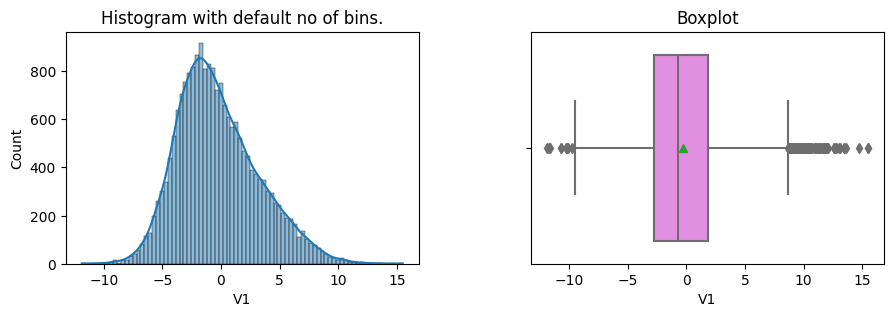

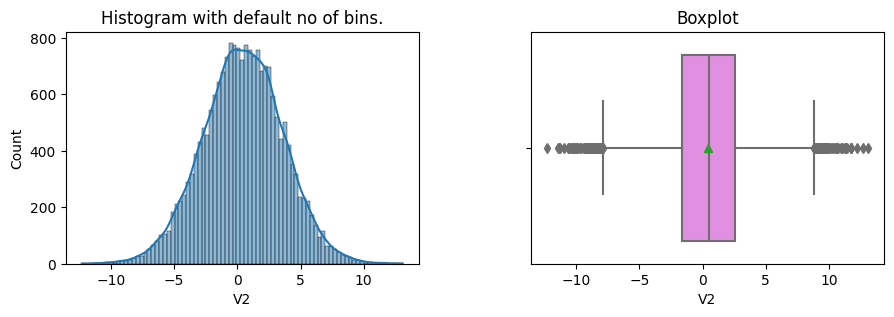

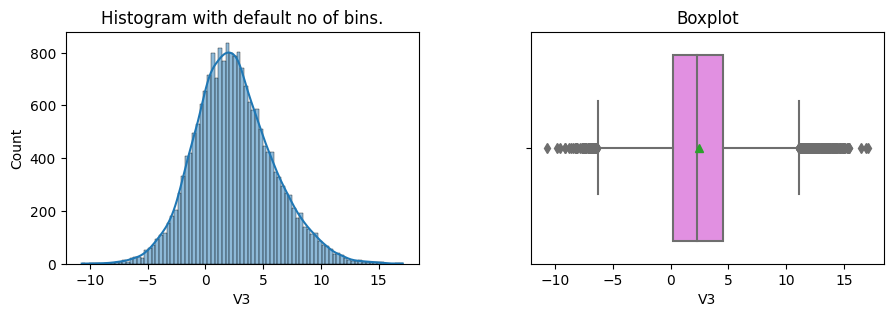

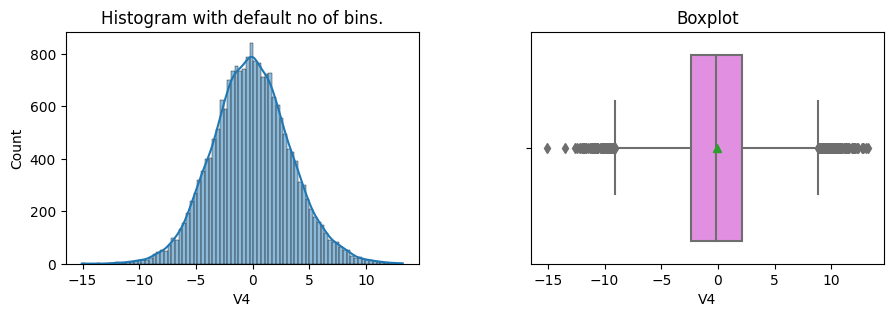

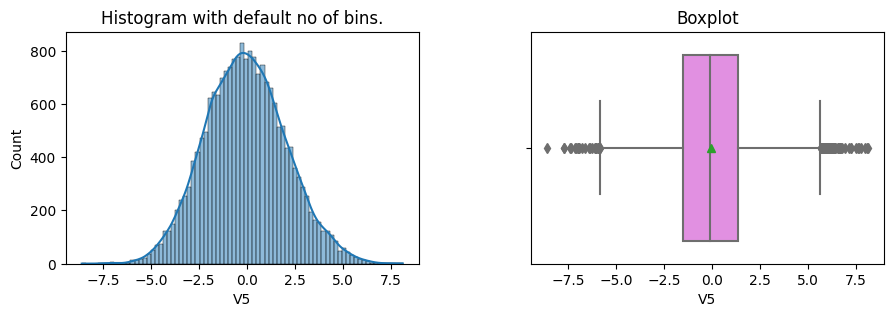

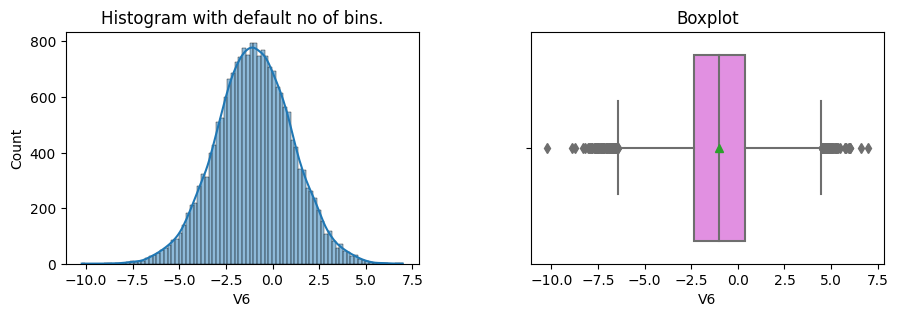

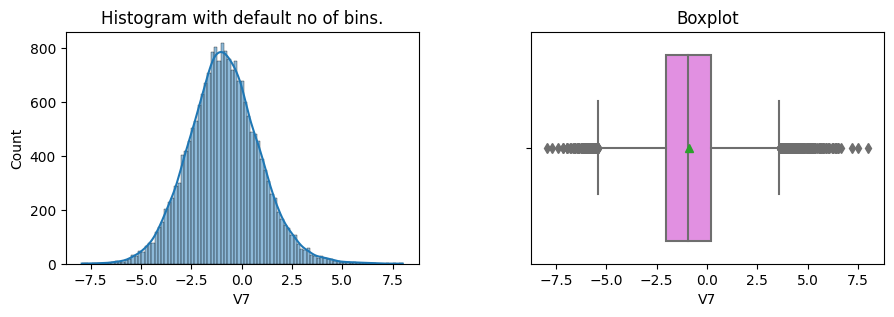

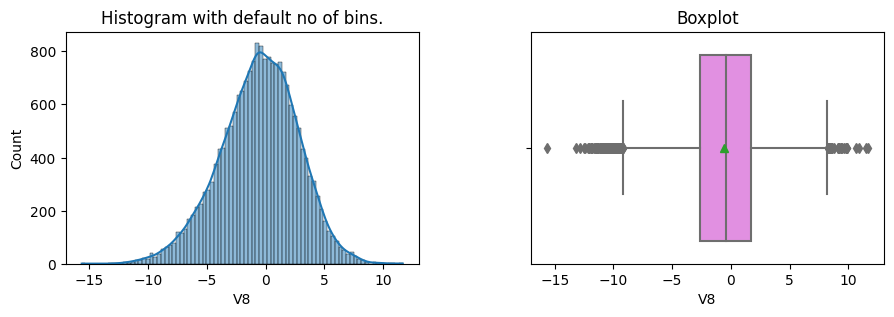

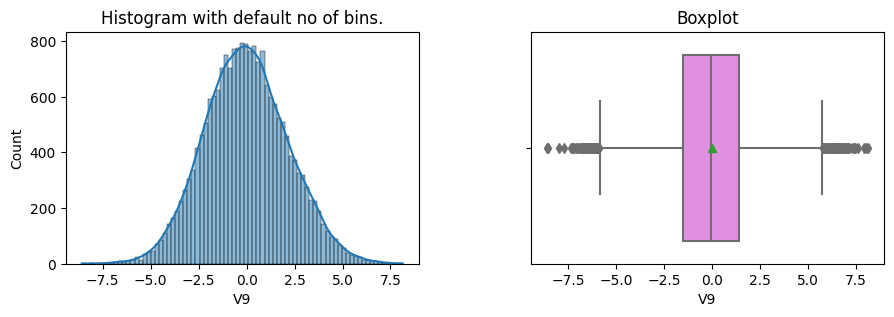

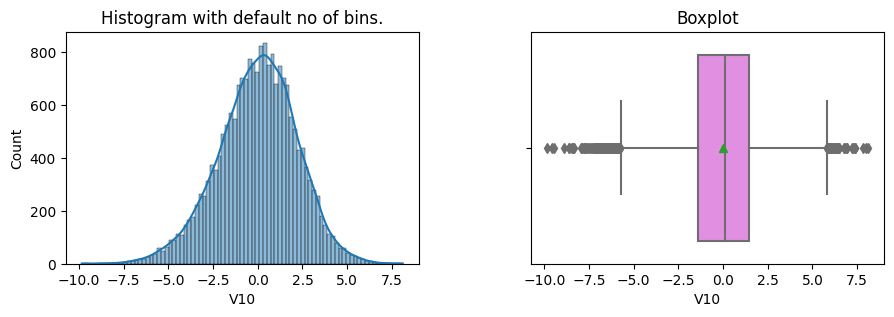

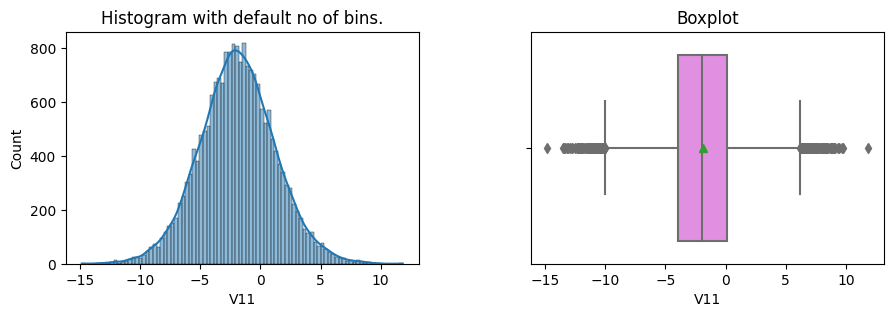

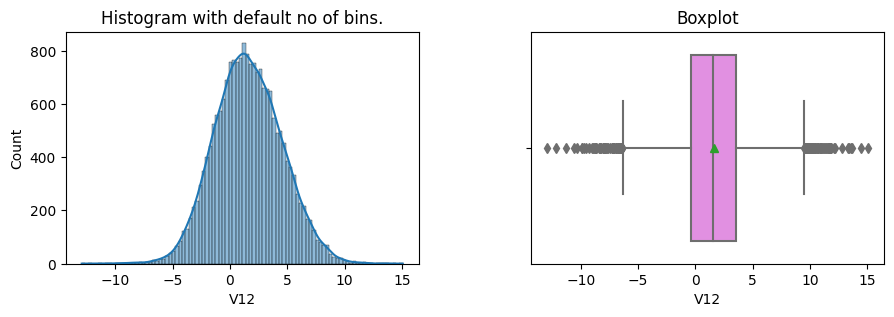

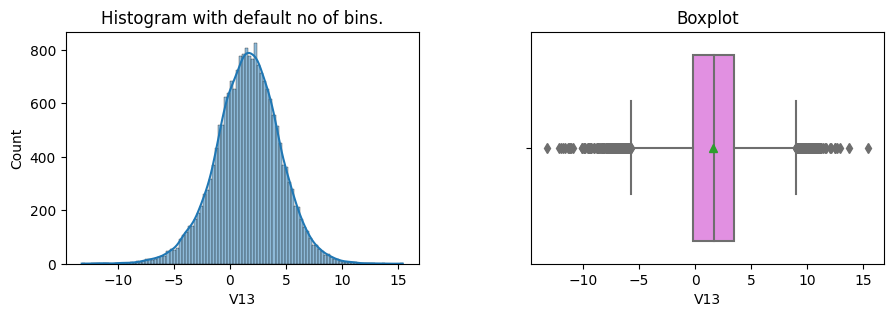

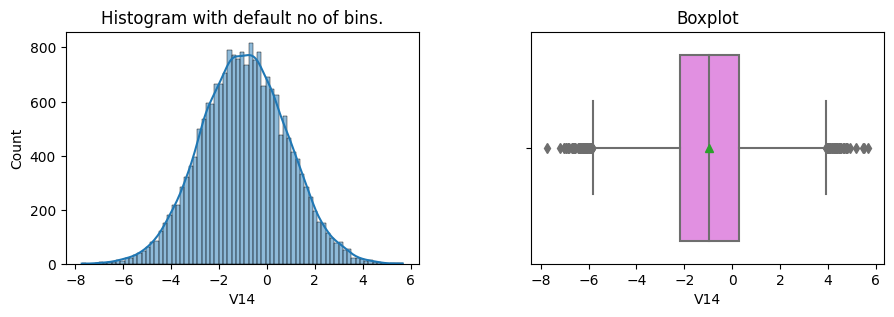

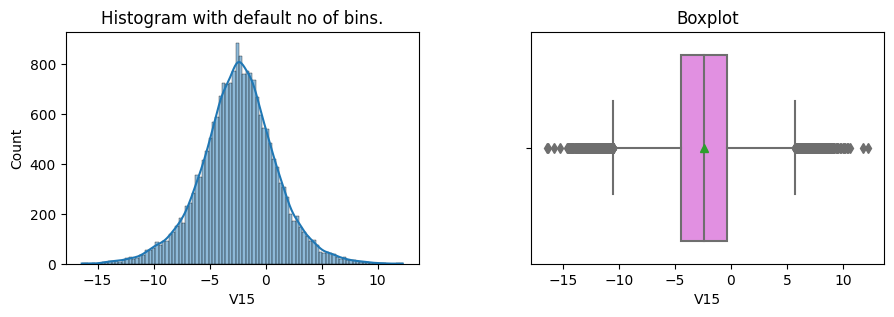

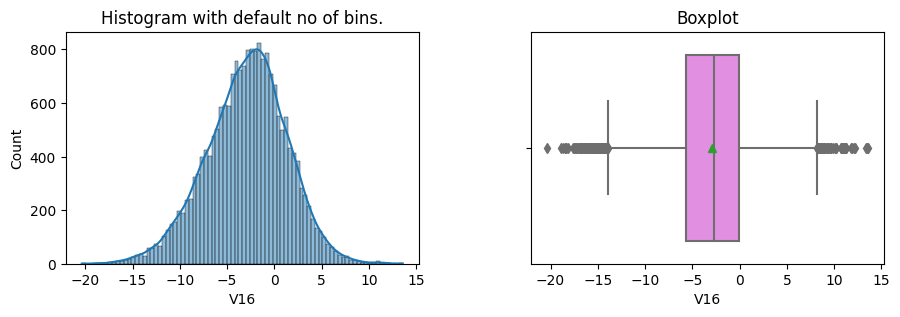

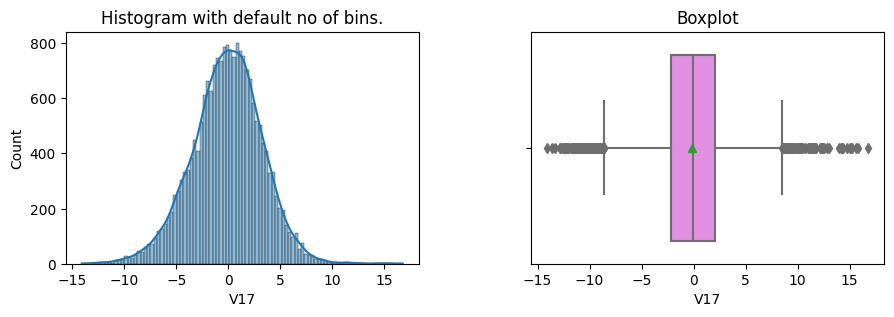

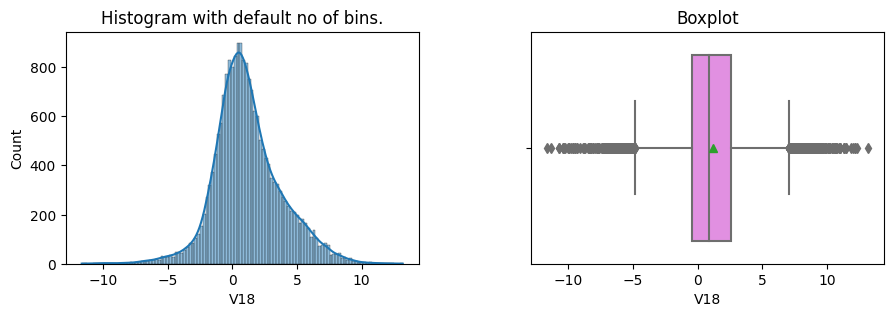

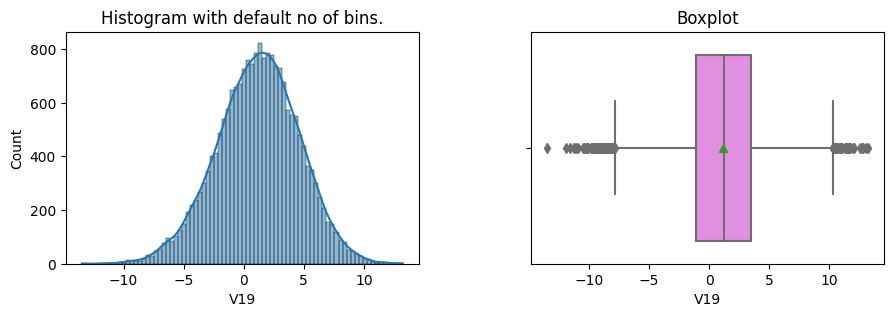

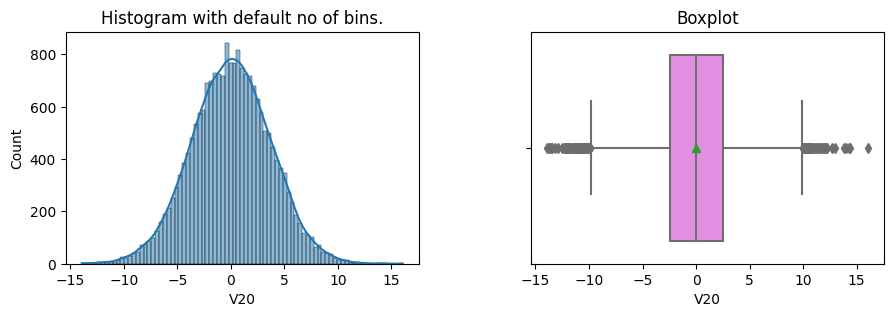

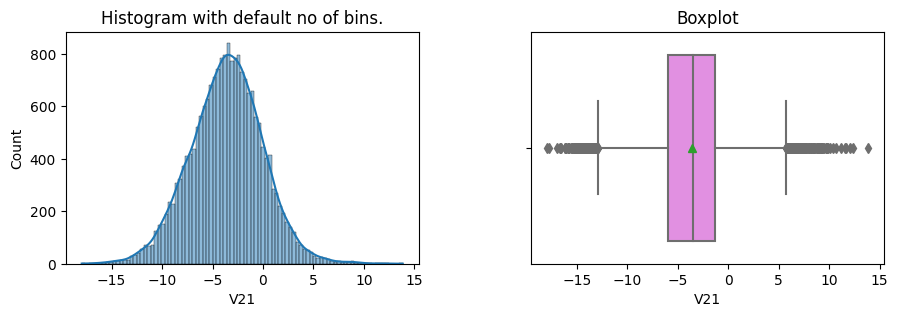

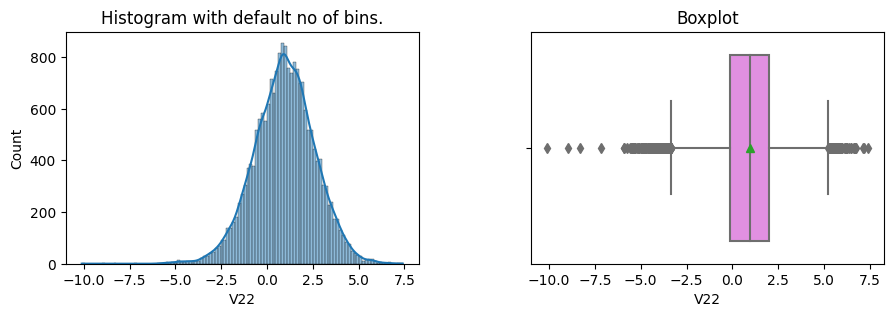

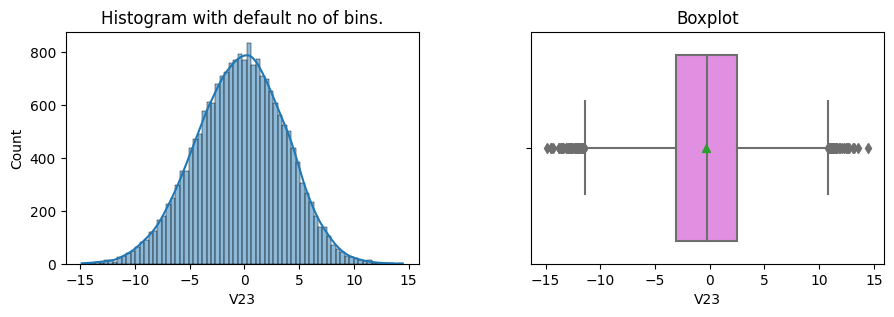

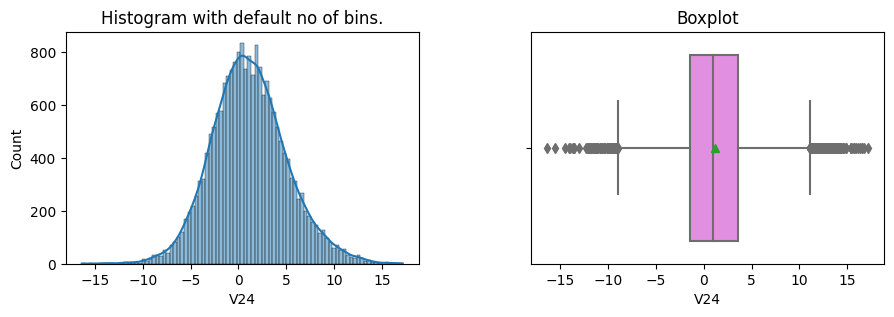

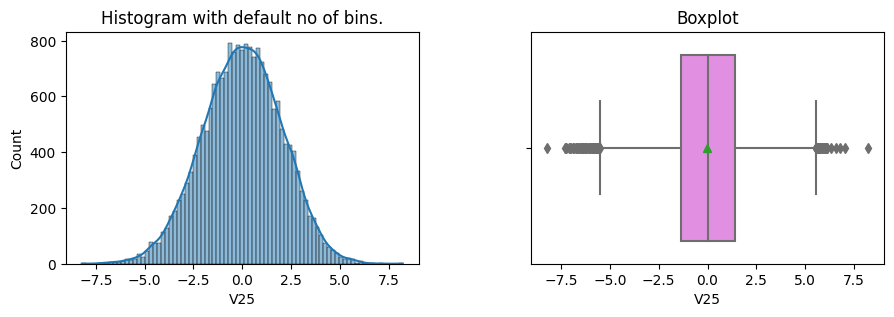

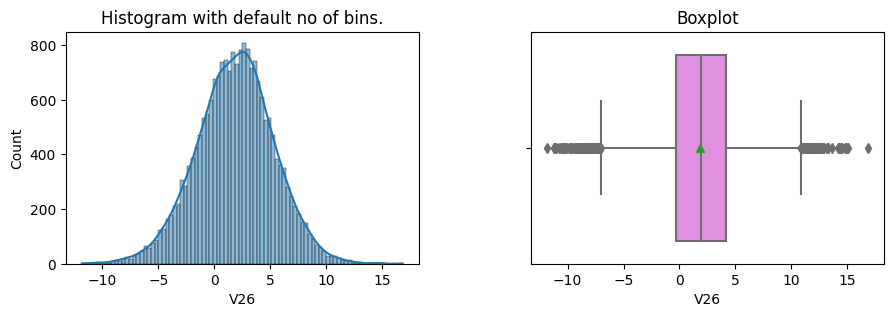

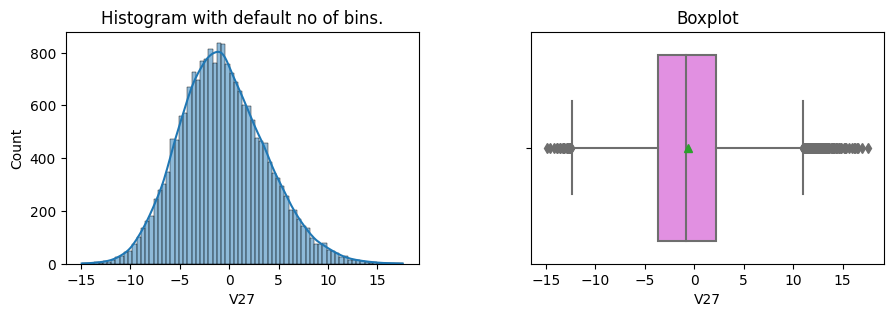

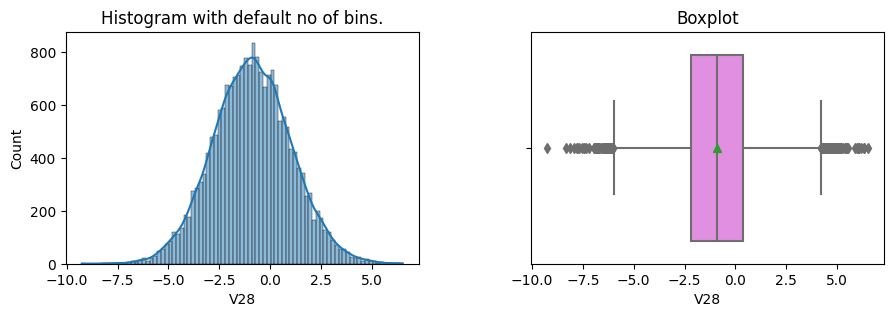

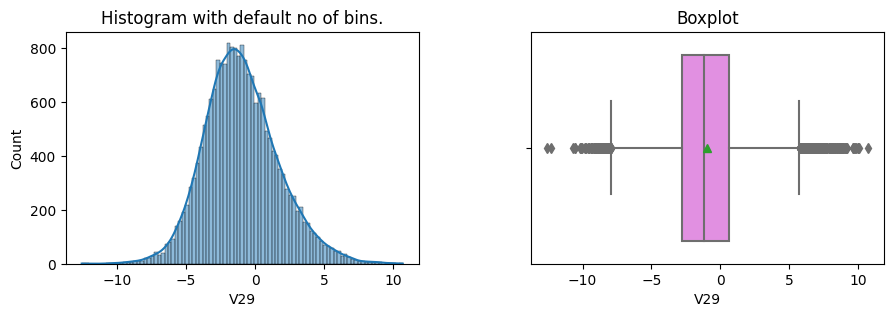

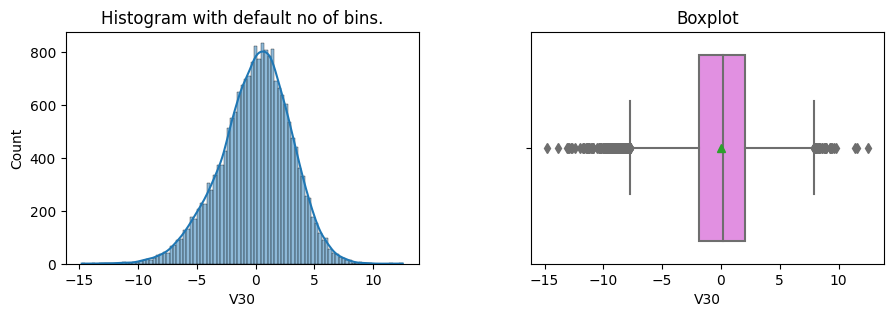

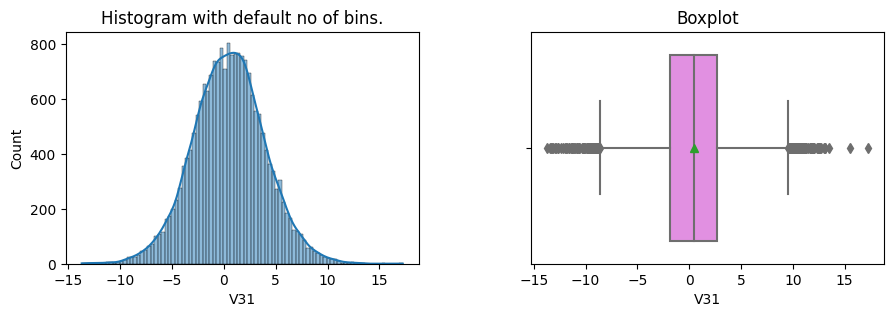

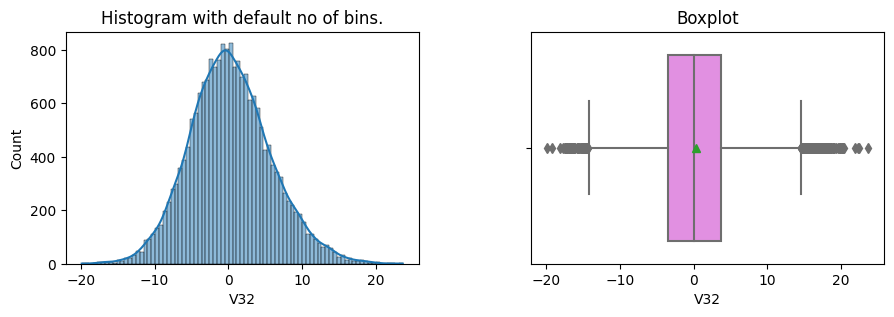

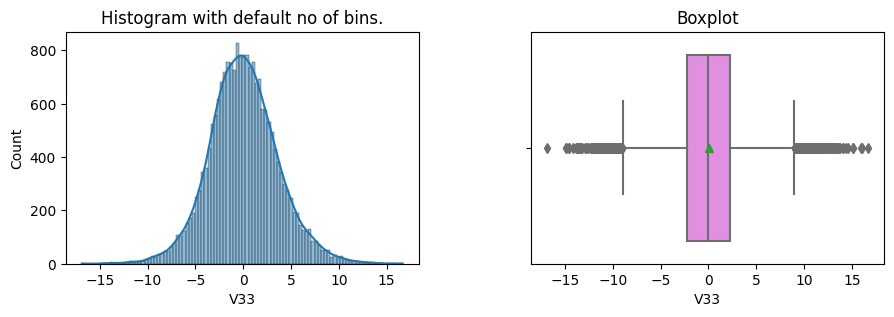

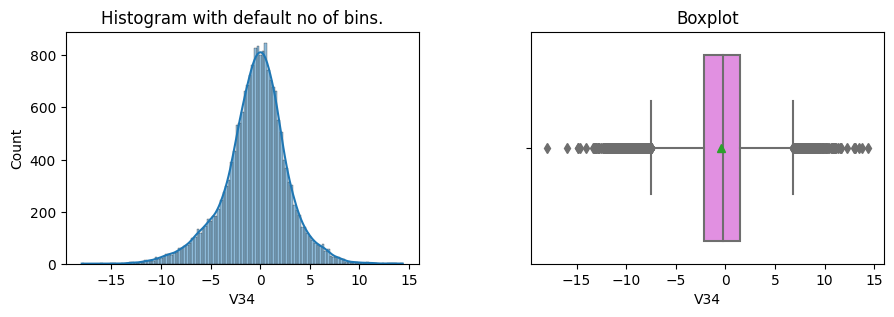

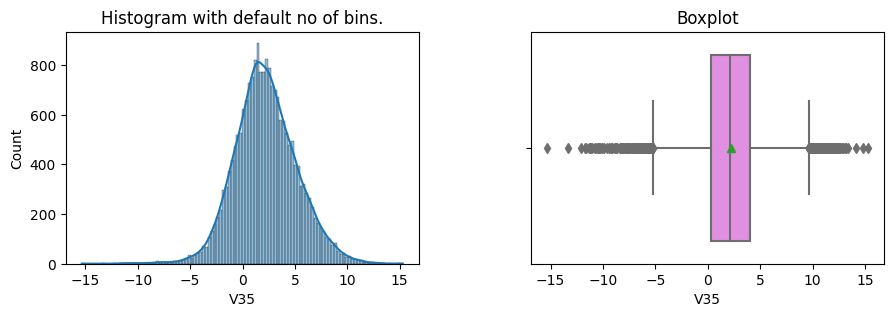

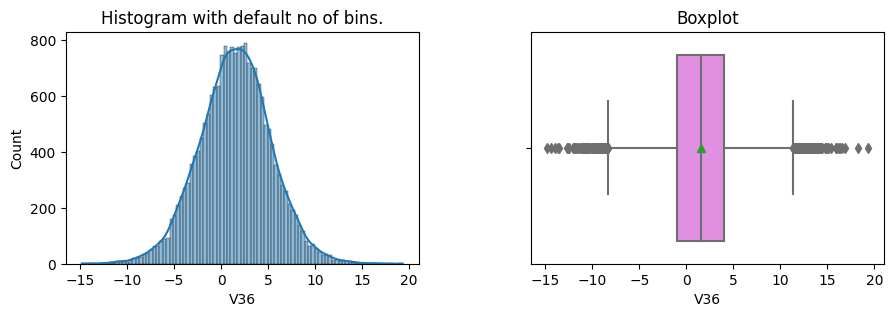

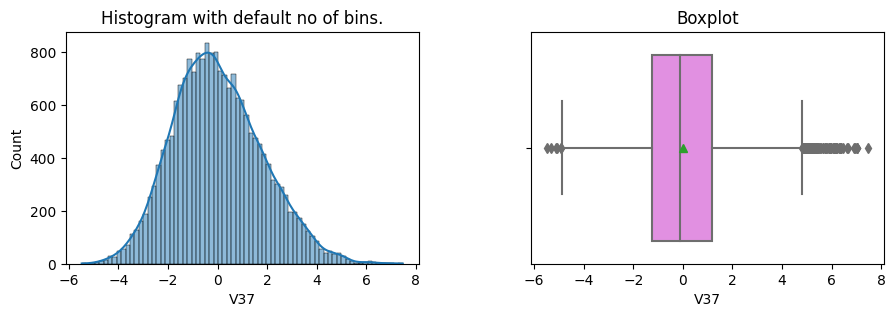

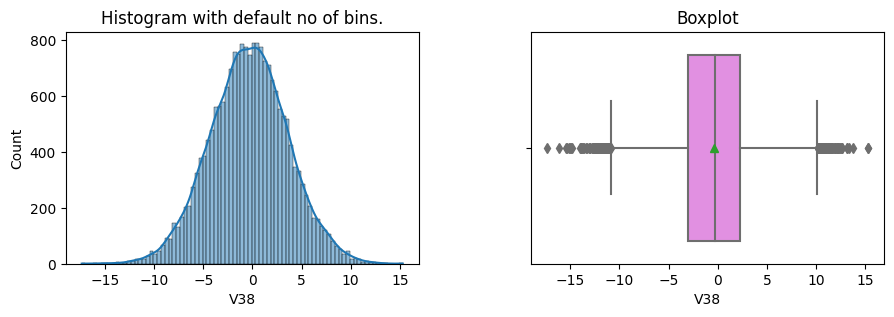

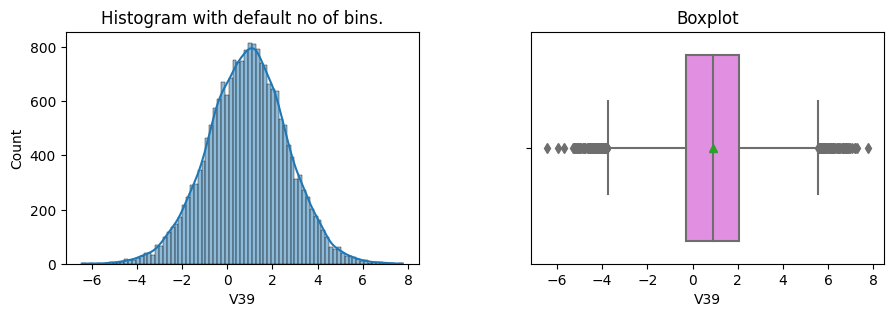

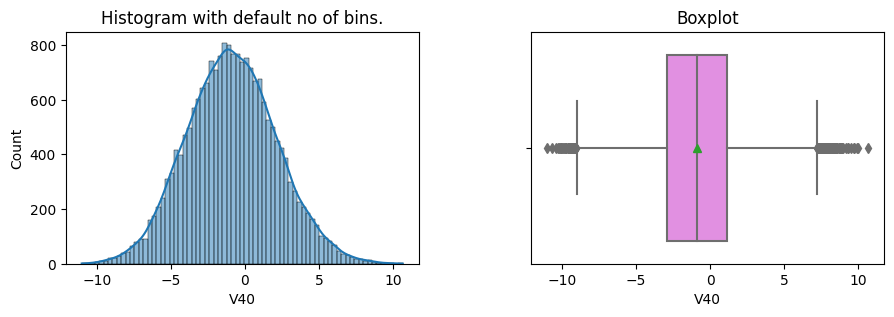

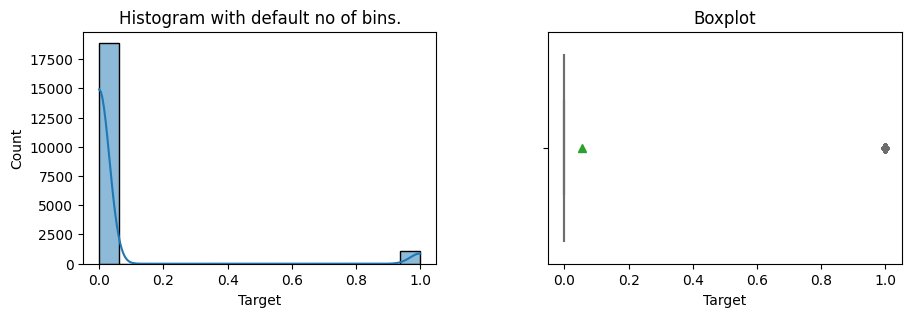

In [ ]:
# Plotting histograms and boxplots for all the variables in one go :
for feature in df.columns:
    creating_hist_box(df, feature, bins=None)

Observations:

*   All the features have symmetrical distributions (The skewness present in the data is negligible).   
*   Feature V1 has a range from almost -11.88 to 15.49, with a mean value of -0.27 and a median value of -0.75. The standard deviation of the column is 3.44.
*   Feature V2 has a range from almost -12.32 to 13.09, with a mean value of 0.44 and a median value of 0.47. The standard deviation of the column is 3.15.
*   Feature V3 has a range from almost -10.71 to 17.09, with a mean value of 2.48 and a median value of 2.26. The standard deviation of the column is 3.39.
*   Feature V4 has a range from almost -15.08 to 13.24, with a mean value of -0.08 and a median value of -0.14. The standard deviation of the column is 3.43.
*   Feature V5 has a range from almost -8.60 to 8.13, with a mean value of -0.05 and a median value of -0.10. The standard deviation of the column is 2.10.
*   Feature V18 has a range from almost -11.64 to 13.18, with a mean value of 1.19 and a median value of 0.88. The standard deviation of the column is 2.59.
*   The mean, median, and ranges of the other features can be stated similarly.
*   There are extreme values on both the higher and lower ends of the distribution for all the columns.



#### Target column

In [ ]:
# Calculating percentage of classes in 'Target column' in the dataset:
(df['Target'].value_counts()/df.shape[0])*100

0   94.45000
1    5.55000
Name: Target, dtype: float64

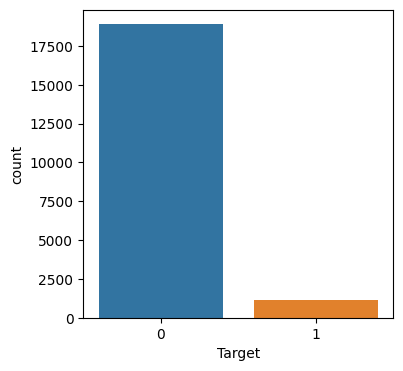

In [ ]:
# Countplot for the column 'Target' in the dataset:
plt.figure(figsize=(4,4))
sns.countplot(data= df, x='Target')
plt.show()

In [ ]:
# Calculating percentage of classes in 'Target column' in the test dataset:
(df_test['Target'].value_counts()/df_test.shape[0])*100

0   94.36000
1    5.64000
Name: Target, dtype: float64

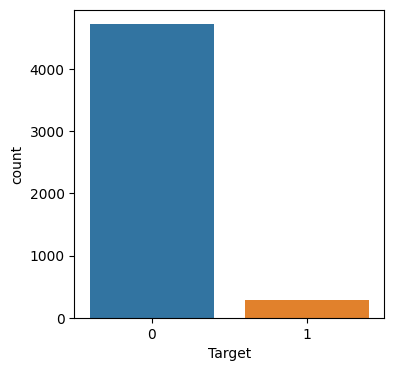

In [ ]:
# Countplot for the column 'Target' in the test dataset:
plt.figure(figsize=(4,4))
sns.countplot(data= df_test, x='Target')
plt.show()

Observations:

*   1 in the target variables represents as 'Failure' and 0 represents 'No failure'.
*   94.45% of cases are no failure scenarios, while only 5.55% of cases represent a failure of a machine/machine part in the dataset.
*   Similarly in the test dataset, 94.36% of cases are no failure scenarios, while only 5.64% of cases represent a failure of a machine/machine.

Dataset | Percentage of No Failure(%) | Percentage of No Failure(%)
-|-|-
Dataset used for creating model | 94.45 | 5.55
Dataset used for testing model | 94.36 | 5.64

*   The distribution of classes in the Target column is imbalanced.



### Multivariate Analysis

#### Correlation between the variables

In [ ]:
df_corr = df.corr()
df_corr

V1       V2       V3       V4       V5       V6       V7  \
V1      1.00000  0.31359  0.38885 -0.29483 -0.51608  0.17552  0.48069   
V2      0.31359  1.00000  0.09518  0.29020  0.38379  0.23395  0.45563   
V3      0.38885  0.09518  1.00000 -0.02883 -0.35963 -0.29164 -0.15627   
V4     -0.29483  0.29020 -0.02883  1.00000  0.08418 -0.47020 -0.19691   
V5     -0.51608  0.38379 -0.35963  0.08418  1.00000  0.15616 -0.07844   
V6      0.17552  0.23395 -0.29164 -0.47020  0.15616  1.00000  0.21091   
V7      0.48069  0.45563 -0.15627 -0.19691 -0.07844  0.21091  1.00000   
V8     -0.36102 -0.38324 -0.41201  0.03491  0.16827 -0.55908  0.09271   
V9      0.39878  0.28060  0.23363  0.26515 -0.29764  0.08455 -0.24442   
V10    -0.02204 -0.48388  0.44616 -0.10706 -0.34374 -0.11689 -0.17685   
V11     0.29131  0.15894 -0.33464 -0.36361 -0.21222  0.71048  0.53066   
V12    -0.14490 -0.15906 -0.16627 -0.23521 -0.01802 -0.39591  0.39733   
V13     0.05609 -0.38192  0.32955 -0.27295 -0.33350 -0.22905 -0.49383   
V14    -0.27368 -0.85353 -0.22297 -0.22193 -0.14621 -0.34670 -0.32323   
V15     0.41326  0.22168 -0.06160 -0.15072 -0.14659  0.14533  0.86787   
V16    -0.33479 -0.24158 -0.53350 -0.19447  0.26699 -0.08418  0.40129   
V17    -0.34779  0.16468 -0.41389  0.60670  0.32819 -0.45430  0.02787   
V18    -0.39006 -0.30363 -0.26784 -0.41362  0.43262  0.28616 -0.56163   
V19     0.12778  0.11910  0.40237  0.59639 -0.50448 -0.41880  0.13563   
V20    -0.34133 -0.58942 -0.03952  0.41201 -0.36051 -0.69524 -0.41324   
V21    -0.39201 -0.06482 -0.65833 -0.08582  0.38396  0.22340  0.47070   
V22     0.20727 -0.09602 -0.19401 -0.03330 -0.08992 -0.06814 -0.27778   
V23    -0.43678 -0.18139 -0.78558  0.03691  0.45663 -0.18656 -0.05008   
V24    -0.51283  0.22193 -0.26533  0.51610  0.66264 -0.19885 -0.21054   
V25     0.67560 -0.12710  0.59568 -0.26990 -0.60253 -0.19047  0.20194   
V26     0.22272  0.78744  0.45976  0.10666  0.40546  0.14722  0.02320   
V27     0.68382 -0.20444  0.49996 -0.58849 -0.66280  0.21731  0.28941   
V28    -0.28056  0.03271 -0.41177  0.66028 -0.03423 -0.18265  0.18933   
V29    -0.06231  0.17982 -0.44544 -0.18606  0.09309  0.58688  0.31107   
V30    -0.46453 -0.21607 -0.60732  0.12172  0.14106  0.15310 -0.25039   
V31     0.08486 -0.04245  0.46373 -0.36818  0.30193 -0.11576 -0.03400   
V32    -0.63328 -0.11582 -0.36743  0.38346  0.61978 -0.29247 -0.45884   
V33    -0.28992  0.20339 -0.21951 -0.05222  0.45889  0.58737 -0.26708   
V34    -0.01943 -0.28110  0.22575  0.29750 -0.60711 -0.40131  0.23244   
V35     0.14270 -0.05478  0.50141  0.34076 -0.34127 -0.31707 -0.43894   
V36    -0.12495 -0.58067  0.43834 -0.55796 -0.04551 -0.24740 -0.28003   
V37    -0.35061 -0.43735 -0.50248 -0.35665  0.06452 -0.06728 -0.00794   
V38     0.14832  0.65537 -0.07386  0.09099  0.17184  0.62872  0.46906   
V39    -0.12090 -0.35054  0.52774 -0.38908 -0.21778 -0.02546 -0.23670   
V40     0.21263  0.15562 -0.30619 -0.66531  0.33533  0.42388  0.47935   
Target  0.07331 -0.00095 -0.21386  0.11079 -0.10053  0.00024  0.23691   

             V8       V9      V10      V11      V12      V13      V14  \
V1     -0.36102  0.39878 -0.02204  0.29131 -0.14490  0.05609 -0.27368   
V2     -0.38324  0.28060 -0.48388  0.15894 -0.15906 -0.38192 -0.85353   
V3     -0.41201  0.23363  0.44616 -0.33464 -0.16627  0.32955 -0.22297   
V4      0.03491  0.26515 -0.10706 -0.36361 -0.23521 -0.27295 -0.22193   
V5      0.16827 -0.29764 -0.34374 -0.21222 -0.01802 -0.33350 -0.14621   
V6     -0.55908  0.08455 -0.11689  0.71048 -0.39591 -0.22905 -0.34670   
V7      0.09271 -0.24442 -0.17685  0.53066  0.39733 -0.49383 -0.32323   
V8      1.00000 -0.61173 -0.17986 -0.19394  0.67403 -0.10431  0.54524   
V9     -0.61173  1.00000 -0.29305 -0.09016 -0.62964  0.39104 -0.23823   
V10    -0.17986 -0.29305  1.00000 -0.15635 -0.11974  0.06849  0.34351   
V11    -0.19394 -0.09016 -0.15635  1.00000 -0.00489 -0.17865 -0.27531   
V12     0.67403 -0.62964 -0.11974 -0.00489  1.00000 -0.01081  0.13027 

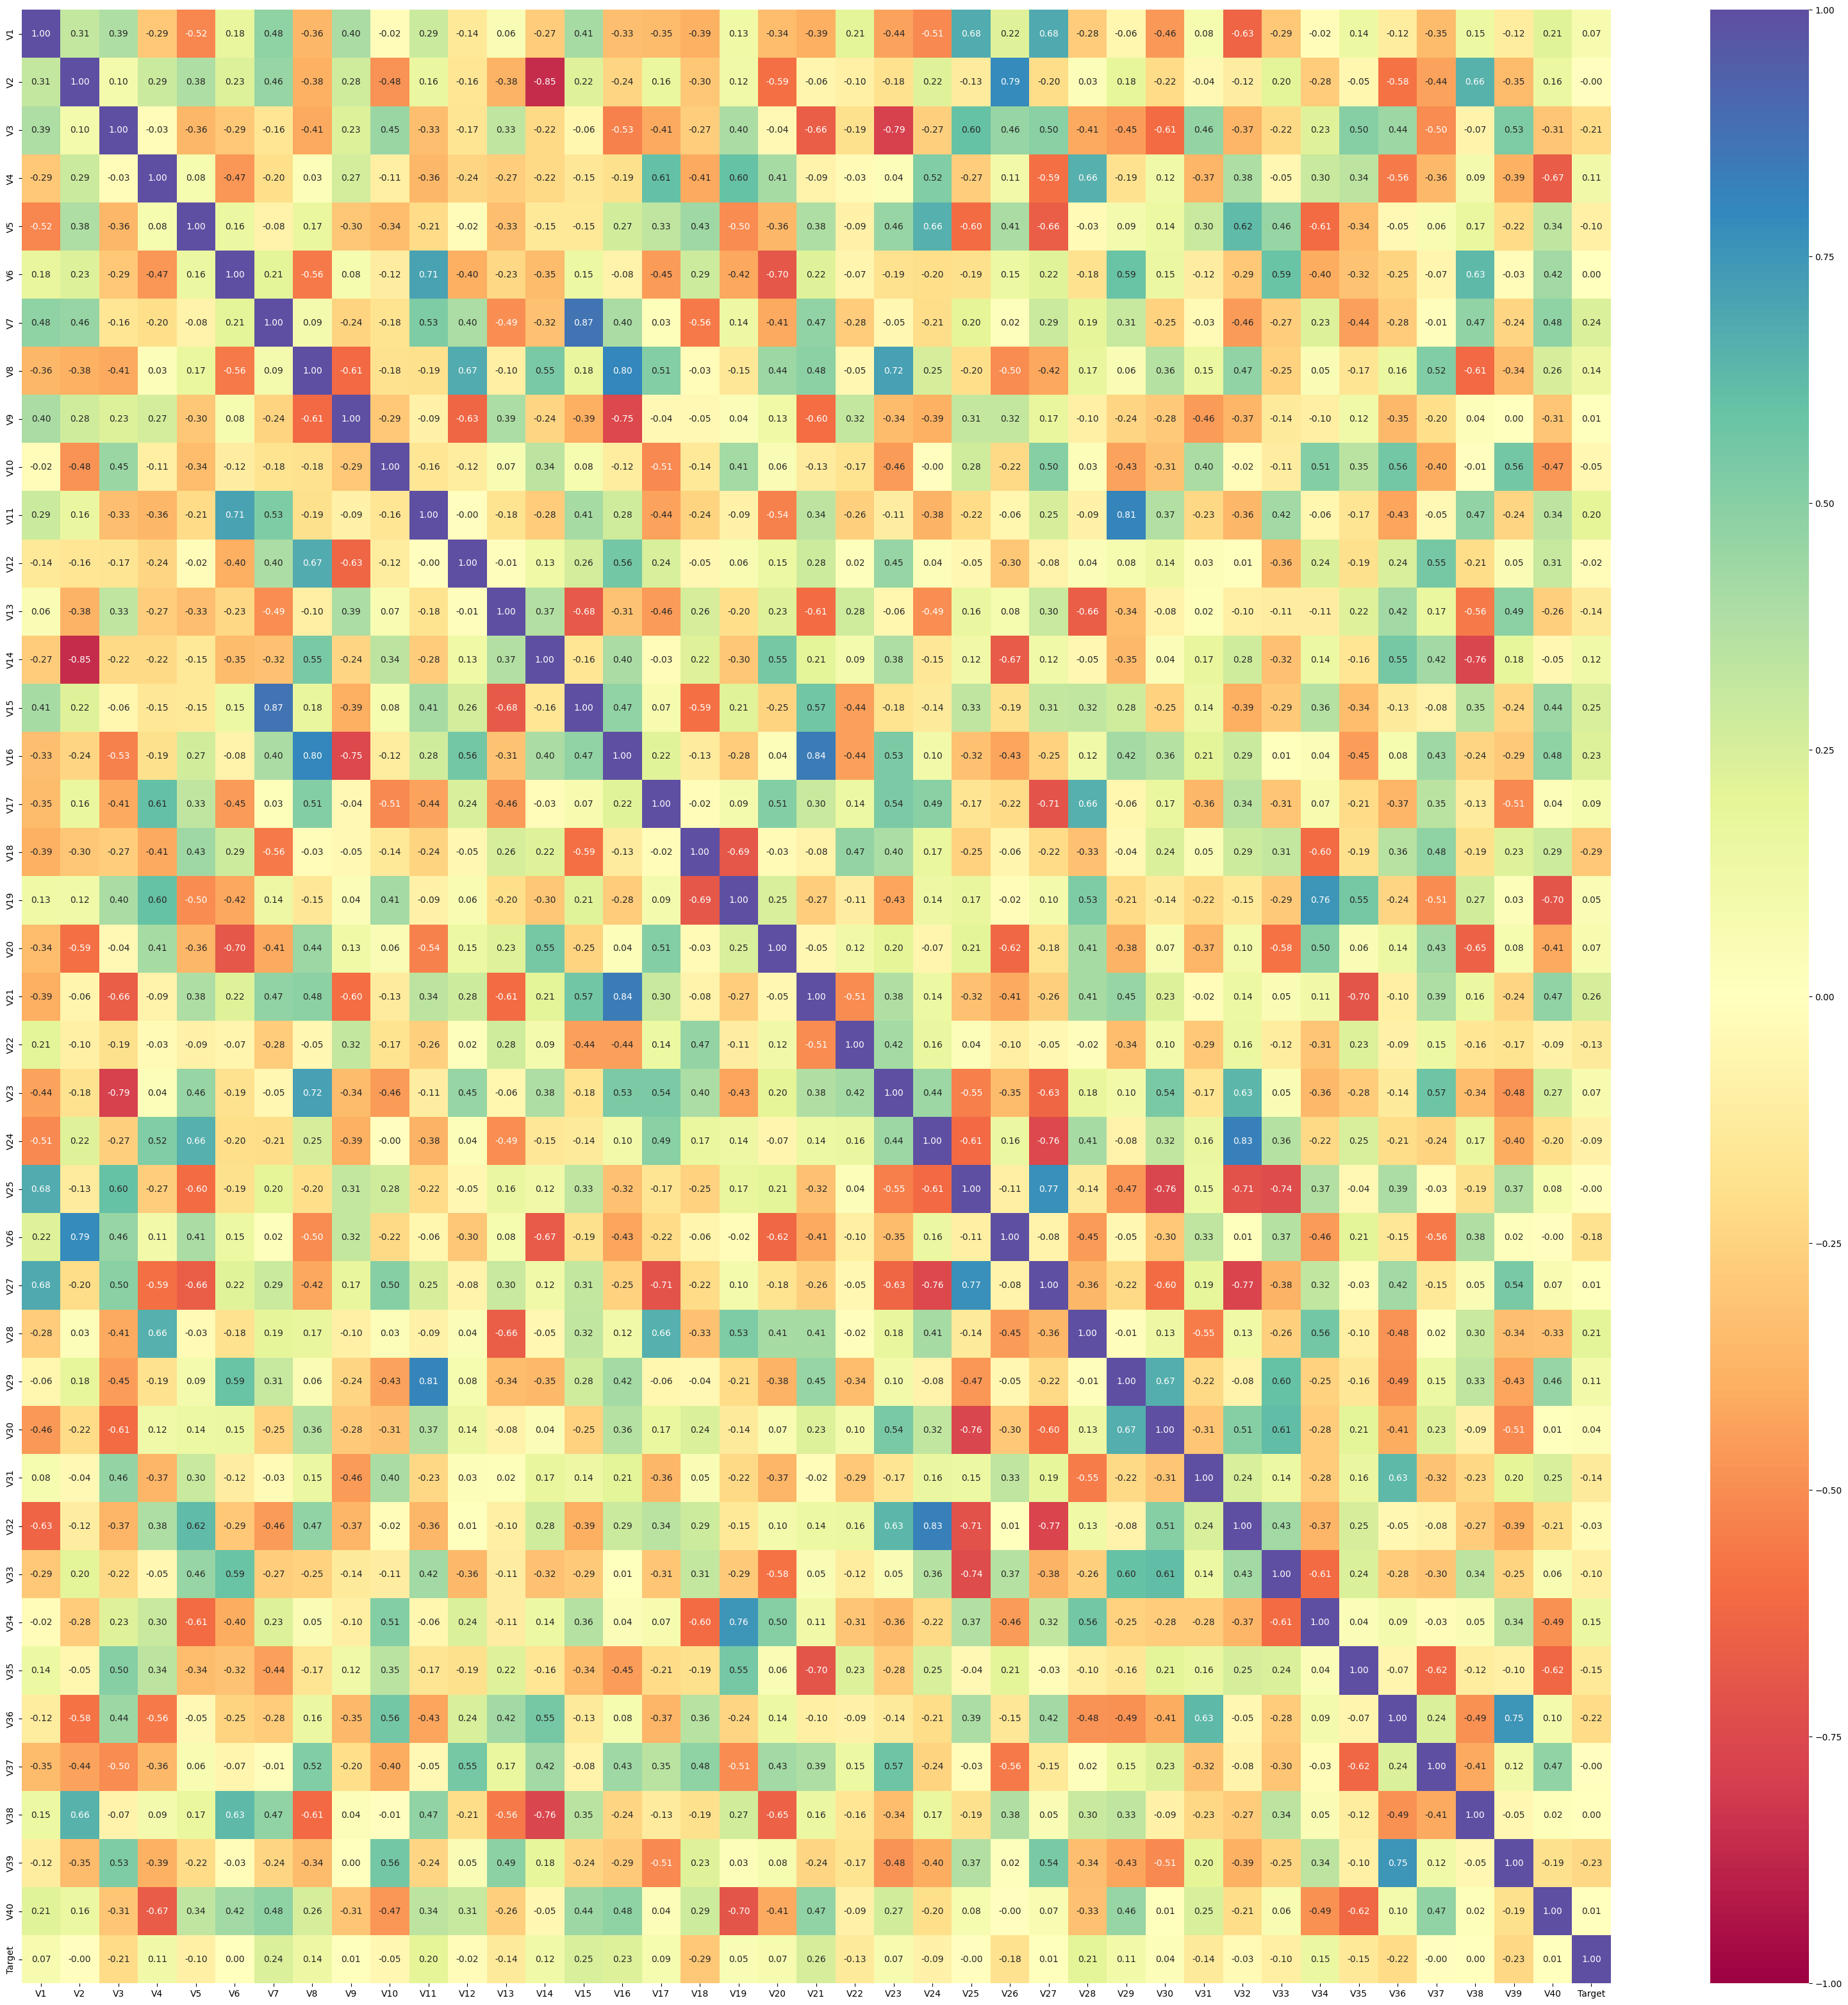

In [ ]:
#Heatmap showing correlation values between different variables.
plt.figure(figsize=(40,40))
sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Observations:

*   The Target column is most positively correlated with variable V21 at 0.26, and most negatively correlated with variable V18 at -0.29.
*   The top 5 positively correlated variables are:

Variable | Correlation value
-|-
V15 & V7 | 0.87
V21 & V16 | 0.84
V32 & V24 | 0.83
V29 & V11 | 0.81
V16 & V8 | 0.80

*   The top 5 negatively correlated variables are:

Variable | Correlation value
-|-
V14 & V2 | -0.85
V23 & V3 | -0.79
V32 & V27 | -0.77
V27 & V24 | -0.76
V30 & V25 | -0.76
V38 & V14 | -0.76
V16 & V9 | -0.75





## **Data Pre-processing**

### Outlier Treatment

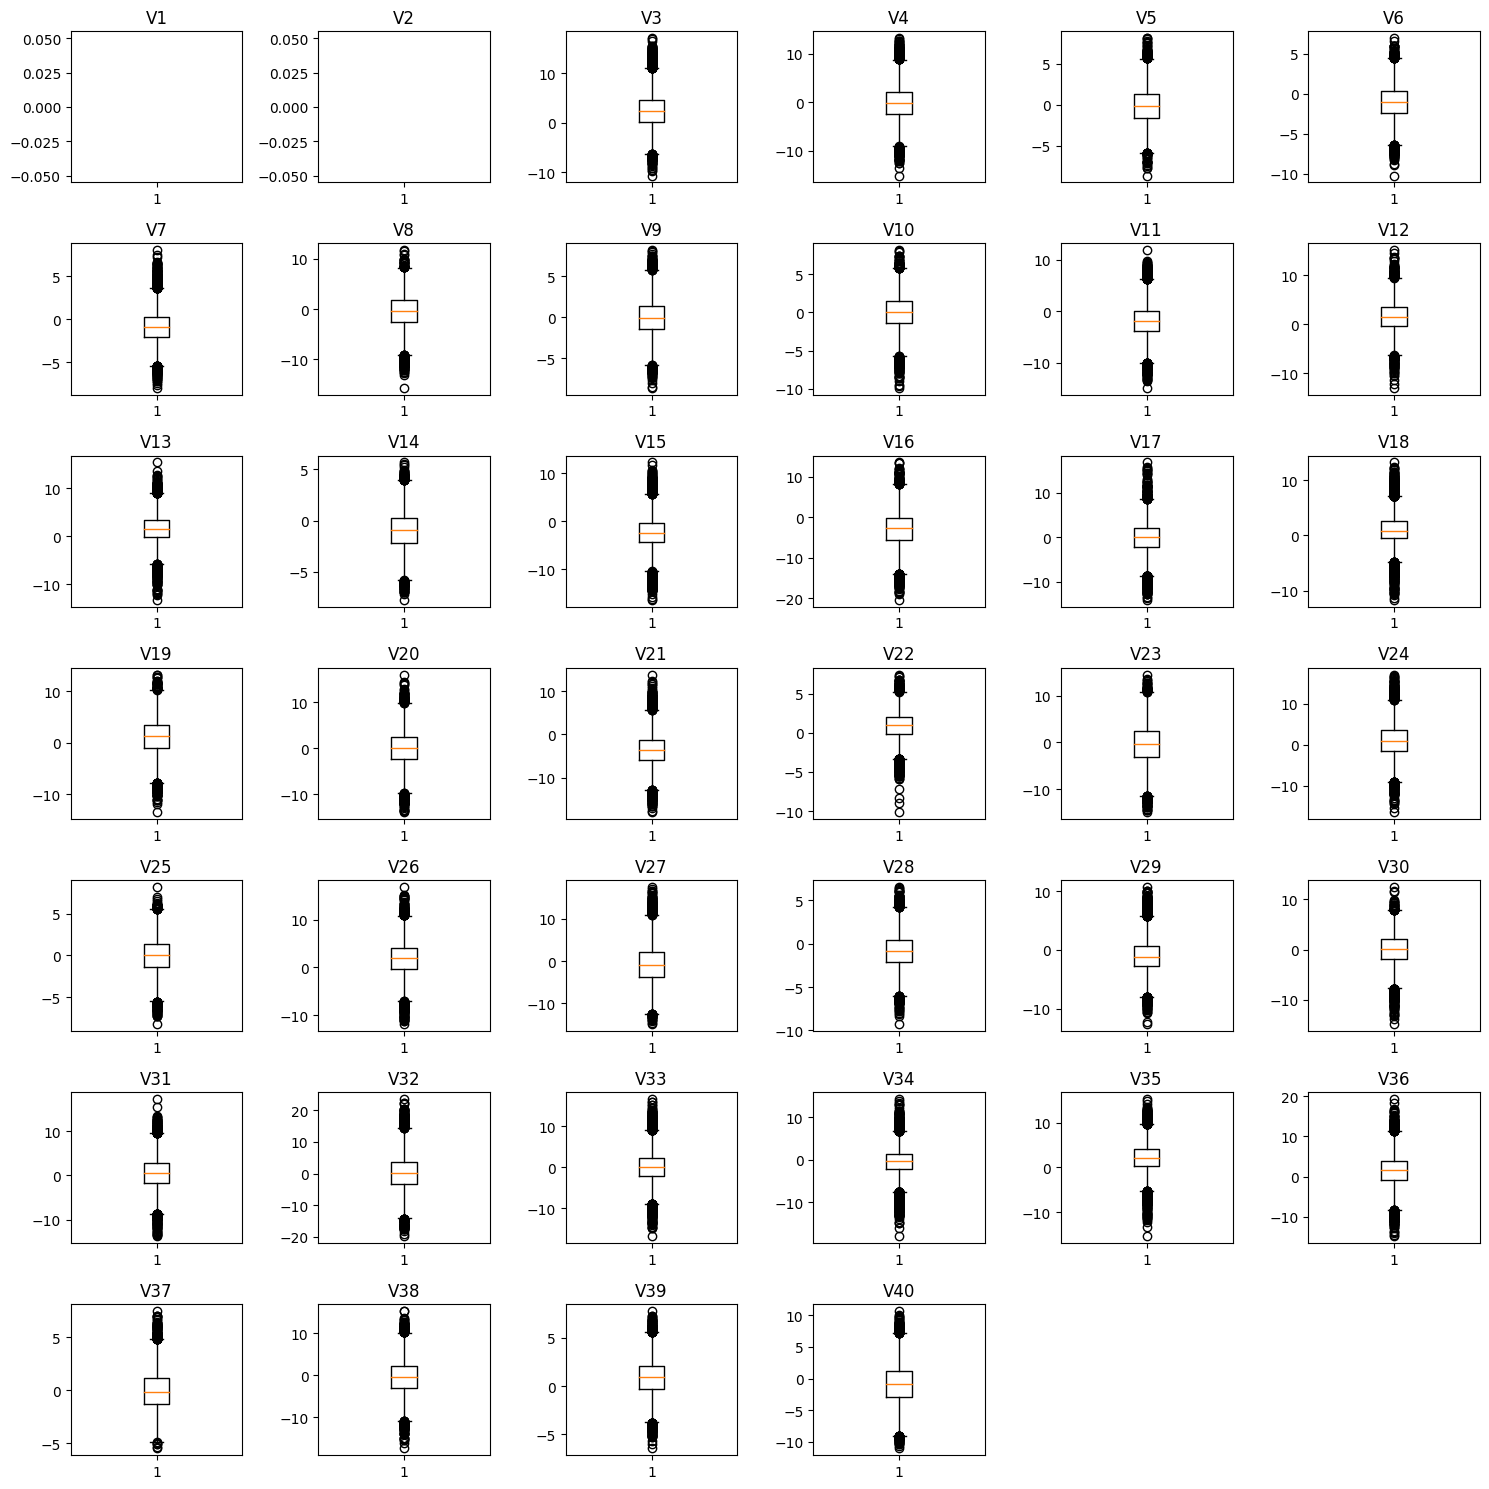

In [ ]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include='float').columns.tolist()

plt.figure(figsize=(15, 15))

for i, variable in enumerate(numeric_columns):
    plt.subplot(7, 6, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

Observations:

*   There are quite a few outliers in the data. We will not treat them as they are proper values.

### Data Preparation for Modeling

In [ ]:
# Splitting training data into independent(X) and dependent(y) variables:
X = df.drop(["Target"], axis=1)
y = df["Target"]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 20000 entries, 0 to 19999
Series name: Target
Non-Null Count  Dtype
--------------  -----
20000 non-null  int64
dtypes: int64(1)
memory usage: 156.4 KB


In [ ]:
# Splitting test data into independent(X) and dependent(y) variables:
X_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [ ]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Target
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [ ]:
# Since we already have a separate test set,
# Hence, splitting data into training(75%) and validation(25%) set:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [ ]:
# Train data shape:
print(f'Indep training df: {X_train.shape}')
print(f'Dep training df: {y_train.shape}')

Indep training df: (15000, 40)
Dep training df: (15000,)


In [ ]:
# Validation Data shape:
print(f'Indep test df: {X_val.shape}')
print(f'Dep test df: {y_val.shape}')

Indep test df: (5000, 40)
Dep test df: (5000,)


In [ ]:
# Test Data shape:
print(f'Indep test df: {X_test.shape}')
print(f'Dep test df: {y_test.shape}')

Indep test df: (5000, 40)
Dep test df: (5000,)


Observations:

*   No. of rows in the training dataset = 15000
*   No. of rows in the validation dataset = 5000
*   No. of rows in the test dataset = 5000
*   No. of columns in the independent training data (ie, X_train dataset) = 40
*   No. of columns in the independent validation data (ie, X_val dataset) = 40
*   No. of columns in the independent test data (ie, X_test dataset) = 40
*   No. of columns in the dependent training data (ie, y_train) = 1
*   No. of columns in the dependent validation data (ie, y_val) = 1
*   No. of columns in the dependent test data (ie, y_test) = 1



### Missing value imputation




In [ ]:
# Creating an instace of the imputer
imputer = SimpleImputer(strategy='median')

In [ ]:
# Fitting and transforming the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Checking that no column has missing values in training sets (calculating the percentage of missing values)
X_train.isna().sum()/X_train .shape[0]

V1    0.00000
V2    0.00000
V3    0.00000
V4    0.00000
V5    0.00000
V6    0.00000
V7    0.00000
V8    0.00000
V9    0.00000
V10   0.00000
V11   0.00000
V12   0.00000
V13   0.00000
V14   0.00000
V15   0.00000
V16   0.00000
V17   0.00000
V18   0.00000
V19   0.00000
V20   0.00000
V21   0.00000
V22   0.00000
V23   0.00000
V24   0.00000
V25   0.00000
V26   0.00000
V27   0.00000
V28   0.00000
V29   0.00000
V30   0.00000
V31   0.00000
V32   0.00000
V33   0.00000
V34   0.00000
V35   0.00000
V36   0.00000
V37   0.00000
V38   0.00000
V39   0.00000
V40   0.00000
dtype: float64

In [ ]:
# Transforming the validation data:
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Checking that no column has missing values in validation sets (calculating the percentage of missing values)
X_val.isna().sum()/X_val .shape[0]

V1    0.00000
V2    0.00000
V3    0.00000
V4    0.00000
V5    0.00000
V6    0.00000
V7    0.00000
V8    0.00000
V9    0.00000
V10   0.00000
V11   0.00000
V12   0.00000
V13   0.00000
V14   0.00000
V15   0.00000
V16   0.00000
V17   0.00000
V18   0.00000
V19   0.00000
V20   0.00000
V21   0.00000
V22   0.00000
V23   0.00000
V24   0.00000
V25   0.00000
V26   0.00000
V27   0.00000
V28   0.00000
V29   0.00000
V30   0.00000
V31   0.00000
V32   0.00000
V33   0.00000
V34   0.00000
V35   0.00000
V36   0.00000
V37   0.00000
V38   0.00000
V39   0.00000
V40   0.00000
dtype: float64

In [ ]:
# Transforming the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

# Checking that no column has missing values in test sets (calculating the percentage of missing values)
X_test.isna().sum()/X_test .shape[0]

V1    0.00000
V2    0.00000
V3    0.00000
V4    0.00000
V5    0.00000
V6    0.00000
V7    0.00000
V8    0.00000
V9    0.00000
V10   0.00000
V11   0.00000
V12   0.00000
V13   0.00000
V14   0.00000
V15   0.00000
V16   0.00000
V17   0.00000
V18   0.00000
V19   0.00000
V20   0.00000
V21   0.00000
V22   0.00000
V23   0.00000
V24   0.00000
V25   0.00000
V26   0.00000
V27   0.00000
V28   0.00000
V29   0.00000
V30   0.00000
V31   0.00000
V32   0.00000
V33   0.00000
V34   0.00000
V35   0.00000
V36   0.00000
V37   0.00000
V38   0.00000
V39   0.00000
V40   0.00000
dtype: float64

In [ ]:
# Percentage of classes in dataset:
# Target = 0 = No Failure
# Target = 1 = Failure

df['Target'].value_counts()/df.shape[0] *100

0   94.45000
1    5.55000
Name: Target, dtype: float64

In [ ]:
# Percentage of classes in training dataset:
print("Percentage of classes in training set:")
y_train.value_counts(normalize=True)*100

Percentage of classes in training set:


0   94.45333
1    5.54667
Name: Target, dtype: float64

In [ ]:
# Percentage of classes in validation dataset:
print("Percentage of classes in validation set:")
y_val.value_counts(normalize=True)*100

Percentage of classes in validation set:


0   94.44000
1    5.56000
Name: Target, dtype: float64

In [ ]:
# Percentage of classes in testing dataset:
print("Percentage of classes in testing set:")
y_test.value_counts(normalize=True)*100

Percentage of classes in testing set:


0   94.36000
1    5.64000
Name: Target, dtype: float64

Observations:

*   After performing imputations, there are no missing values in the training, validation, and testing datasets.
*   Around 5.55% of observations belong to class 1 (Target = 1 = Failure) and 94.45% of observations belong to class 0 (Target = 0 = No Failure), and this is preserved in the train, validation and test sets.

## **Model evaluation criterion**

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures is predicted correctly by the model.
* We would want Recall to be maximized as the greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Defining scorer to be used for cross-validation and hyperparameter tuning:
scorer = make_scorer(recall_score)

## **Model Building**

### Model Building with Original Data:

In [ ]:
# Empty list to store all the models
models = []

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

# Empty list to store all model's CV scores
results = []

# Empty list to store name of the models
names = []

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Setting number of splits equal to 5
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold)
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.4927566553639709
Decision Tree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
Adaboost: 0.6309140754635308
GBM: 0.7066661857008874
Xgboost: 0.7956208065796118

Validation Performance:

Logistic Regression: 0.48201438848920863
Decision Tree: 0.7050359712230215
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
Adaboost: 0.6762589928057554
GBM: 0.7230215827338129
Xgboost: 0.8201438848920863


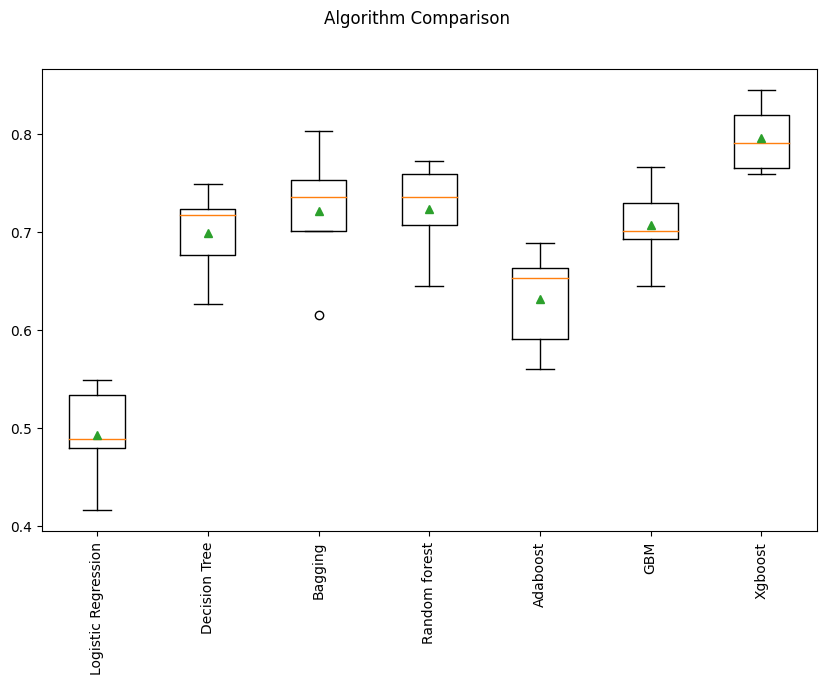

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 6))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
plt.xticks(rotation = 90)
plt.show()

Observations:

*   Following are the recall scores of the models on training and validation sets:

Model | Training Recall score (Mean) (%) | Validation Recall Score (%)
-|-|-
Logistic Regression | 49.27 | 48.20
Adaboost | 63.09 | 67.62
Decision Tree | 69.83 | 70.50
Gradient Boosting | 70.67 | 72.30
Bagging | 72.11 | 73.02
Random Forest | 72.35 | 72.66
XGBoost | 79.56 | 82.01

*   The performance of the models on the training set is close to the performance on the validation set. So we can say that the models are not overfitting the data.
*   Xgboost is giving the highest cross-validated recall score followed by Random Forest and Bagging. These models are giving generalized results as well.




### Model Building with OverSampled Data:


In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 



In [ ]:
print("Before OverSampling, the shape of X_train: {}".format(X_train.shape))
print("Before OverSampling, the shape of y_train: {} \n".format(y_train.shape))

Before OverSampling, the shape of X_train: (15000, 40)
Before OverSampling, the shape of y_train: (15000,) 



In [ ]:
# Synthetic Minority Over Sampling Technique:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 



In [ ]:
print("After OverSampling, the shape of X_train: {}".format(X_train_over.shape))
print("After OverSampling, the shape of y_train: {} \n".format(y_train_over.shape))

After OverSampling, the shape of X_train: (28336, 40)
After OverSampling, the shape of y_train: (28336,) 



Observations:

*   Before oversampling:
    *   Number of rows in independent training (X_train) set = 15000
    *   Number of rows in dependent training (y_train) set = 15000
    *   Number of rows with Target = 0 = 14168
    *   Number of rows with Target = 1 = 832
*   After oversampling:
    *   Number of rows in independent training (X_train) set = 28336
    *   Number of rows in dependent training (y_train) set = 28336
    *   Number of rows with Target = 0 = 14168
    *   Number of rows with Target = 1 = 14168



In [ ]:
# Empty list to store all the models
models = []

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

# Empty list to store all model's CV scores
results_over = []

# Empty list to store name of the models
names = []


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Setting number of splits equal to 5
    cv_result = cross_val_score(estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold)
    results_over.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.883963699328486
Decision Tree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
Adaboost: 0.8978689011775473
GBM: 0.9256068151319724
Xgboost: 0.989554053559209

Validation Performance:

Logistic Regression: 0.8489208633093526
Decision Tree: 0.7769784172661871
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
Adaboost: 0.8561151079136691
GBM: 0.8776978417266187
Xgboost: 0.8669064748201439


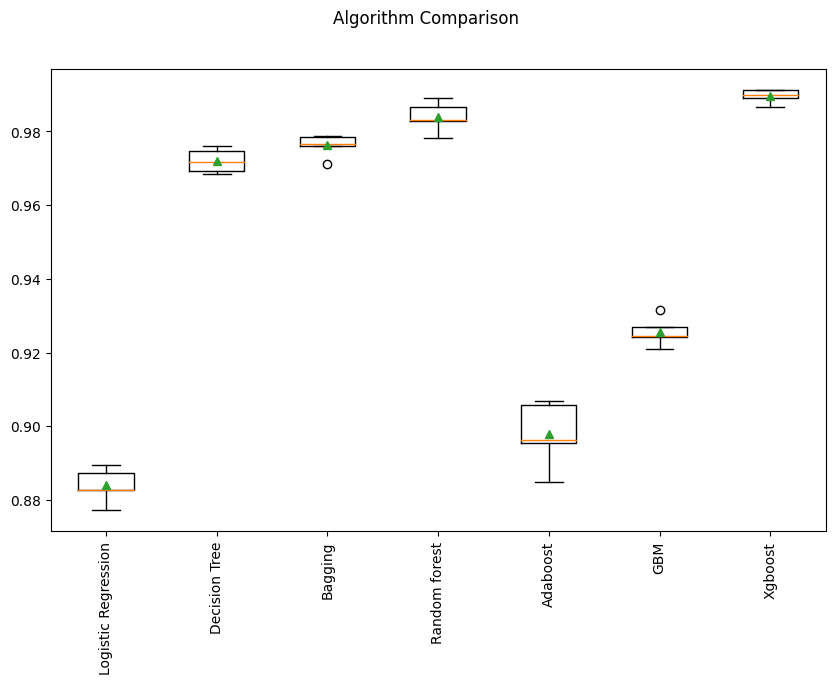

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 6))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over, showmeans=True)
ax.set_xticklabels(names)
plt.xticks(rotation = 90)
plt.show()

Observations:

*   Following are the recall scores of the models on training and validation sets after oversampling the data:

Model | Training Recall score (Mean) (%) | Validation Recall Score (%)
-|-|-
Logistic Regression | 88.40 | 84.89
Adaboost | 89.79 | 85.61
Gradient Boosting | 92.56 | 87.77
Decision Tree | 97.20 | 77.70
Bagging | 97.62 | 83.45
Random Forest | 98.39 | 84.89
XGBoost | 98.95 | 86.69
  
*   The performance of the models on the training set has improved upon using oversampled data (as compared to when using original datasets).
*   The Gradient Boosting, Logistic Regression, and Adaboost models have been able to replicate their scores for the validation set. So we can say that these models give better-generalized results as compared to the original data.
*   However, the models built using Decision Tree, Bagging, Random Forest, and XGBoost algorithms have not been able to replicate the same for the validation set, which indicates that these models are overfitting the training data.

### Model Building with UnderSampled Data:

In [ ]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 



In [ ]:
print("Before UnderSampling, the shape of train_X: {}".format(X_train.shape))
print("Before UnderSampling, the shape of train_y: {} \n".format(y_train.shape))

Before UnderSampling, the shape of train_X: (15000, 40)
Before UnderSampling, the shape of train_y: (15000,) 



In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 



In [ ]:
print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



Observations:

*   Before undersampling:
    *   Number of rows in independent training (X_train) set = 15000
    *   Number of rows in dependent training (y_train) set = 15000
    *   Number of rows with Target = 0 = 14168
    *   Number of rows with Target = 1 = 832
*   After undersampling:
    *   Number of rows in independent training (X_train) set = 1664
    *   Number of rows in dependent training (y_train) set = 1664
    *   Number of rows with Target = 0 = 832
    *   Number of rows with Target = 1 = 832

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_under = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # Setting number of splits equal to 5
    cv_result = cross_val_score(estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold)
    results_under.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.8726138085275232
Decision Tree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
Adaboost: 0.8666113556020489
GBM: 0.8990621167303946
Xgboost: 0.9074742082100858

Validation Performance:

Logistic Regression: 0.8525179856115108
Decision Tree: 0.841726618705036
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
Adaboost: 0.8489208633093526
GBM: 0.8884892086330936
Xgboost: 0.9028776978417267


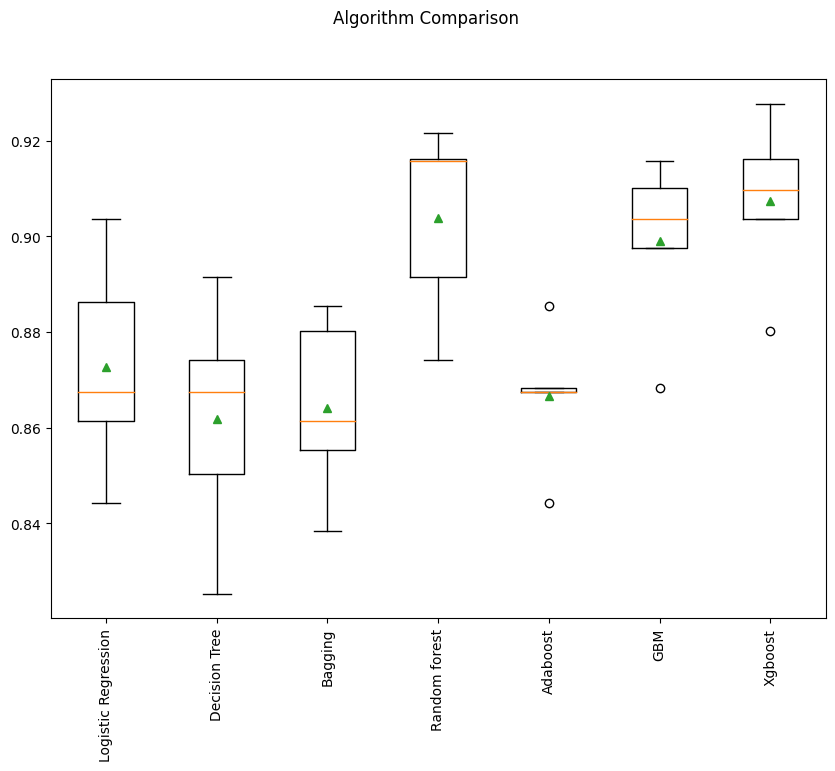

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_under, showmeans=True)
ax.set_xticklabels(names)
plt.xticks(rotation = 90)
plt.show()

Observations:

*   Following are the recall scores of the models on training and validation sets after undersampling the data:

Model | Training Recall score (Mean) (%) | Validation Recall Score (%)
-|-|-
Decision Tree | 86.18 | 84.17
Bagging | 86.42 | 87.05
AdaBoost | 86.66 | 84.89
Logistic Regression | 87.26 | 85.25
Gradient Boosting | 89.91 | 88.85
Random Forest | 90.39 | 89.21
XGBoost | 90.75 | 90.29
  
*   The performance of the models on the training set has improved upon using undersampled data (as compared to when using original datasets).
*   The models have been able to replicate the performance on the validation set, which indicates that the models have been able to generalize well using undersampling.
*   Xgboost is giving the highest cross-validated recall score followed by Random Forest and Gradient Boosting.

The following models have been hyperparameter tuned further to get better performance:

Model | Dataset Used
-|-
Gradient Boost Model | Oversampled Dataset
Adaboost Model | Oversampled Dataset
Logistic Regression Model| Oversampled Dataset
XGBoost Model | Undersampled Dataset
Random Forest Model | Undersampled Dataset
Gradient Boosting Model | Undersampled Dataset
Adaboost Model | Undersampled Dataset
Logistic Regression Model | Undersampled Dataset



## **Hyperparameter Tuning**

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Gradient Boosting with oversampled data

In [ ]:
# defining model
tuned_gbm_oversamp = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_gbm_oversamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:


In [ ]:
tuned_gbm_oversamp = GradientBoostingClassifier(
    max_features= 0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

tuned_gbm_oversamp.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
model_tuned_gbm_oversamp_train_perf=model_performance_classification_sklearn(tuned_gbm_oversamp,X_train_over,y_train_over)
print("Training performance:")
model_tuned_gbm_oversamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.99340 0.99238    0.99441 0.99339

In [ ]:
model_tuned_gbm_oversamp_val_perf=model_performance_classification_sklearn(tuned_gbm_oversamp,X_val,y_val)
print("Validation performance:")
model_tuned_gbm_oversamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.96940 0.85612    0.67806 0.75676

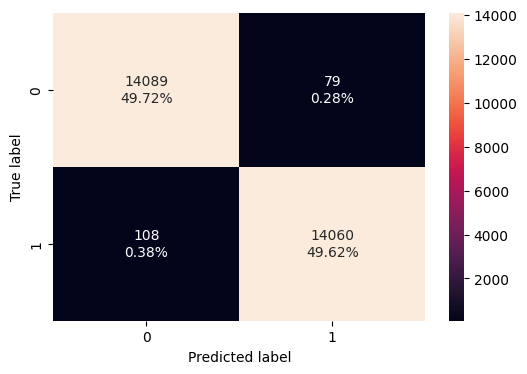

In [ ]:
# Confusion matrix for model 'tuned_gbm_oversamp' on training set:
confusion_matrix_sklearn(tuned_gbm_oversamp, X_train_over, y_train_over)

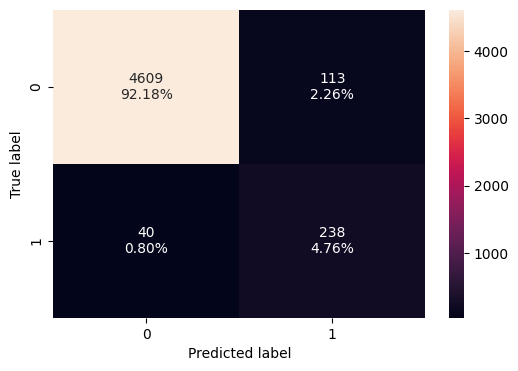

In [ ]:
# Confusion matrix for model 'tuned_gbm_oversamp' on validation set:
confusion_matrix_sklearn(tuned_gbm_oversamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_gbm_oversamp'
print (pd.DataFrame(tuned_gbm_oversamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V36 0.37106
V16 0.13084
V18 0.09109
V14 0.07847
V11 0.04123


Observations on Gradient Boosting model 'tuned_gbm_oversamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   subsample= 0.7
    *   n_estimators= 125
    *   max_features= 0.5
    *   learning_rate= 1

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 99.34 | 96.94
Recall | 99.24 | 85.61
Precision | 99.44 | 67.81
F1-Score |  99.34 | 75.68

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.28 | 2.26
False Negative | 0.38 | 0.80

*   Since the recall of the model is around 99% on the train data and the recall of the model is 85.61% on the validation data, we can say that this model is overfitting the training data. Also, there is a huge difference between training and validation scores for other metrics (precision and F1 score).  Hence, this model will not generalize well on unseen data.

*   The top 5 most important features according to this model are V36, V16, V18, V14, and V11.

### AdaBoosting with oversampled data

In [ ]:
# defining model
tuned_abc_oversamp = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV

param_grid = { "n_estimators": [100, 150, 200],
              "learning_rate": [0.2, 0.05],
               "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                  DecisionTreeClassifier(max_depth=2, random_state=1),
                                  DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_abc_oversamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:


In [ ]:
tuned_abc_oversamp = AdaBoostClassifier(n_estimators= 200,
                                        learning_rate= 0.2,
                                        base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1),
                                        random_state = 1)


tuned_abc_oversamp.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [ ]:
model_tuned_abc_oversamp_train_perf=model_performance_classification_sklearn(tuned_abc_oversamp,X_train_over,y_train_over)
print("Training performance:")
model_tuned_abc_oversamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.99178 0.98828    0.99524 0.99175

In [ ]:
model_tuned_abc_oversamp_val_perf=model_performance_classification_sklearn(tuned_abc_oversamp,X_val,y_val)
print("Validation performance:")
model_tuned_abc_oversamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.97920 0.85252    0.79000 0.82007

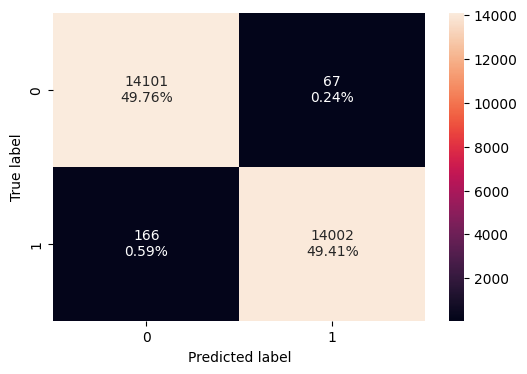

In [ ]:
# Confusion matrix for model 'tuned_abc_oversamp' on training set:
confusion_matrix_sklearn(tuned_abc_oversamp, X_train_over, y_train_over)

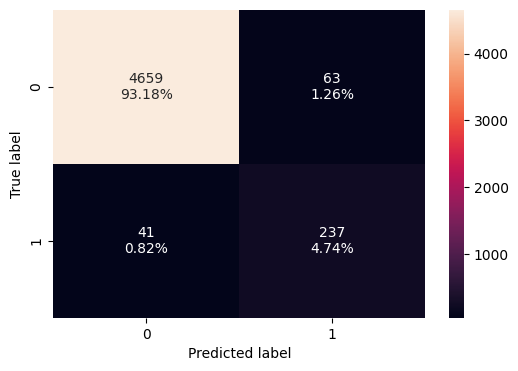

In [ ]:
# Confusion matrix for model 'tuned_abc_oversamp' on validation set:
confusion_matrix_sklearn(tuned_abc_oversamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_abc_oversamp'
print (pd.DataFrame(tuned_abc_oversamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V30 0.05457
V9  0.04968
V18 0.04686
V12 0.04308
V36 0.04057


Observations on AdaBoosting model 'tuned_abc_oversamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   n_estimators= 200
    *   learning_rate= 0.2
    *   base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 99.18 | 97.92
Recall | 98.83 | 85.25
Precision | 99.52 | 79.00
F1-Score | 99.17 | 82.01

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.24 | 1.26
False Negative | 0.59 | 0.82

*   Since the recall of the model is around 99% on the train data and the recall of the model is 85.25% on the validation data, we can say that this model is overfitting the training data. Also, there is a huge difference between training and validation scores for other metrics (precision and F1 score).  Hence, this model will not generalize well on unseen data.

*   The top 5 most important features according to this model are V30, V9, V18, V12, and V36.

### Logistic Regression with oversampled data

In [ ]:
# defining model
tuned_lr_oversamp = LogisticRegression(random_state=1, solver="saga")

# Parameter grid to pass in RandomSearchCV

param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_lr_oversamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8838231041005031:


In [ ]:
tuned_lr_oversamp = LogisticRegression(C=0.1, random_state=1, solver="saga")
tuned_lr_oversamp.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, random_state=1, solver='saga')

In [ ]:
model_tuned_lr_oversamp_train_perf=model_performance_classification_sklearn(tuned_lr_oversamp,X_train_over,y_train_over)
print("Training performance:")
model_tuned_lr_oversamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.88036 0.88396    0.87765 0.88079

In [ ]:
model_tuned_lr_oversamp_val_perf=model_performance_classification_sklearn(tuned_lr_oversamp,X_val,y_val)
print("Validation performance:")
model_tuned_lr_oversamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.86840 0.84892    0.27700 0.41770

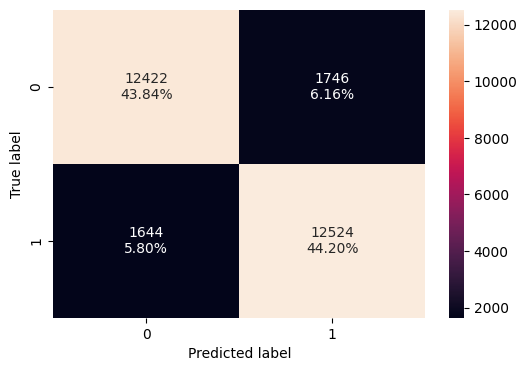

In [ ]:
# Confusion matrix for model 'tuned_lr_oversamp' on training set:
confusion_matrix_sklearn(tuned_lr_oversamp, X_train_over, y_train_over)

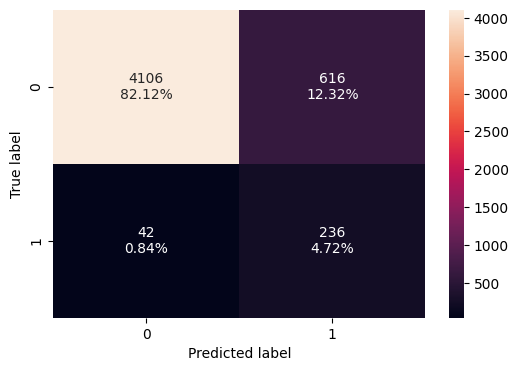

In [ ]:
# Confusion matrix for model 'tuned_lr_oversamp' on validation set:
confusion_matrix_sklearn(tuned_lr_oversamp, X_val, y_val)

Observations on Logistic Regression model 'tuned_lr_oversamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   C= 0.1
    *   solver= 'saga'

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 88.04 | 86.84
Recall | 88.40 | 84.89
Precision | 87.76 | 27.70
F1-Score | 88.08 | 41.77

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 6.16 | 12.32
False Negative | 5.80 | 0.84

*   Since the recall of the model is around 88% on the train data and the recall of the model is 84.89% on the validation data, we can say that this model is generalizing well on the validation data.

*   However, the model does not generalize well in terms of precision and F1 scores as there is a huge gap in these metric values in testing and validation sets.

### XGBoost with undersampled data

In [ ]:
# defining model
tuned_xgb_undersamp = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
             'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_xgb_undersamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer, cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9266503138301709:


In [ ]:
tuned_xgb_undersamp = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=5,
)

tuned_xgb_undersamp.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [ ]:
model_tuned_xgb_undersamp_train_perf=model_performance_classification_sklearn(tuned_xgb_undersamp,X_train_un,y_train_un)
print("Training performance:")
model_tuned_xgb_undersamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.99038 1.00000    0.98113 0.99048

In [ ]:
model_tuned_xgb_undersamp_val_perf=model_performance_classification_sklearn(tuned_xgb_undersamp,X_val,y_val)
print("Validation performance:")
model_tuned_xgb_undersamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.86260 0.91007    0.27650 0.42414

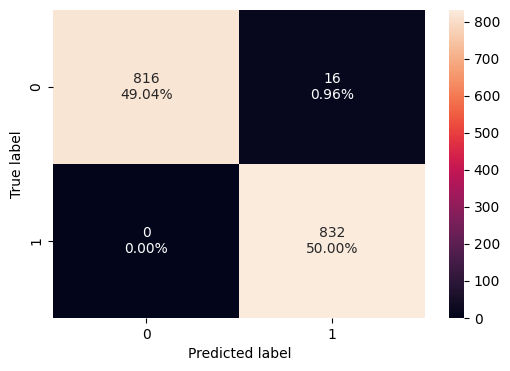

In [ ]:
# Confusion matrix for model 'tuned_xgb_undersamp' on training set:
confusion_matrix_sklearn(tuned_xgb_undersamp, X_train_un, y_train_un)

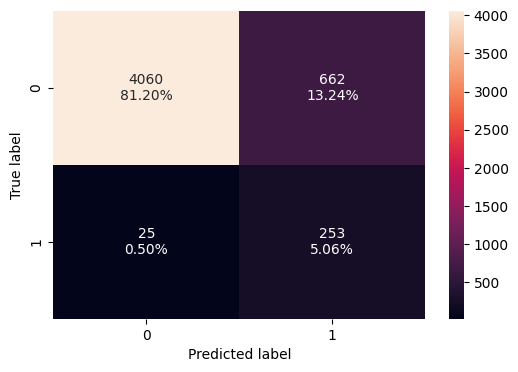

In [ ]:
# Confusion matrix for model 'tuned_xgb_undersamp' on validation set:
confusion_matrix_sklearn(tuned_xgb_undersamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_xgb_undersamp'
print (pd.DataFrame(tuned_xgb_undersamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V36 0.11280
V26 0.03805
V39 0.03687
V14 0.03398
V18 0.03344


Observations on XGBoost model 'tuned_xgb_undersamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   subsample=0.9,
    *   scale_pos_weight=10
    *   n_estimators=250
    *   learning_rate=0.1
    *   gamma= 5

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 99.04 | 86.26
Recall | 100 | 91.01
Precision | 98.11 | 27.65
F1-Score | 99.05 | 42.41

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.96 | 13.24
False Negative | 0 | 0.50

*   Since both the accuracy and the recall of the model is around 100% on the train data and the accuracy of the model is 86.26% and the recall is 91.01% on the validation data, we can say that this model is overfitting the training data. Also, there is a huge difference between training and validation scores for other metrics (precision and F1 score).  Hence, this model will not generalize well on unseen data.

*   The top 5 most important features according to this model are V36, V26, V39, V14, and V18.

### Random Forest with undersampled data

In [ ]:
# defining model
tuned_rf_undersamp = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
               "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_rf_undersamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer, cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8978140105331505:


In [ ]:
tuned_rf_undersamp = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=1,
)

tuned_rf_undersamp.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

In [ ]:
model_tuned_rf_undersamp_train_perf=model_performance_classification_sklearn(tuned_rf_undersamp,X_train_un,y_train_un)
print("Training performance:")
model_tuned_rf_undersamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.98798 0.97716    0.99877 0.98785

In [ ]:
model_tuned_rf_undersamp_val_perf=model_performance_classification_sklearn(tuned_rf_undersamp,X_val,y_val)
print("Validation performance:")
model_tuned_rf_undersamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.94360 0.88489    0.49597 0.63566

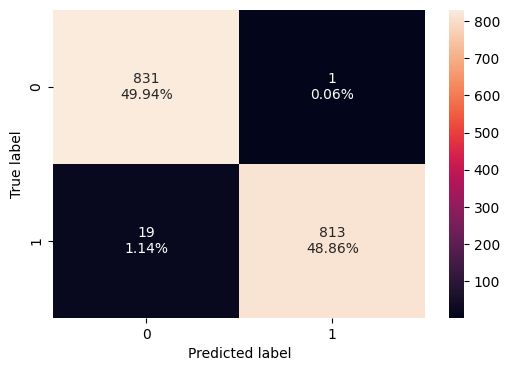

In [ ]:
# Confusion matrix for model 'tuned_rf_undersamp' on training set:
confusion_matrix_sklearn(tuned_rf_undersamp, X_train_un, y_train_un)

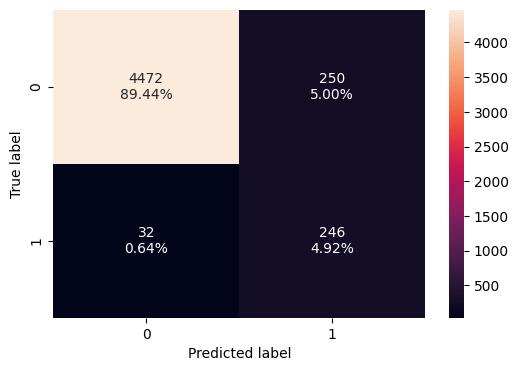

In [ ]:
# Confusion matrix for model 'tuned_rf_undersamp' on validation set:
confusion_matrix_sklearn(tuned_rf_undersamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_rf_undersamp'
print (pd.DataFrame(tuned_rf_undersamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V36 0.09551
V18 0.09385
V39 0.06373
V3  0.04753
V15 0.04671


Observations on Random Forest model 'tuned_rf_undersamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   n_estimators= 250
    *   min_samples_leaf= 1
    *   max_samples': 0.6
    *   max_features= 'sqrt'

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 98.80 | 94.36
Recall | 97.72 | 88.49
Precision | 99.88 | 49.60
F1-Score | 98.78 | 63.57

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.06 | 5.00
False Negative | 1.14 | 0.64

*   Since the recall of the model is around 99% on the train data and the recall of the model is 88.5% on the validation data, we can say that this model is overfitting the training data. Also, there is a huge difference between training and test scores for other metrics (precision and F1 score).  Hence, this model will not generalize well on unseen data.

*   The top 5 most important features according to this model are V36, V18, V39, V3, and V15.

### Gradient Boosting with undersampled data

In [ ]:
# defining model
tuned_gbm_undersamp = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1],
               "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_gbm_undersamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9014212538777866:


In [ ]:
tuned_gbm_undersamp = GradientBoostingClassifier(
    max_features= 0.7,
    random_state=1,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.5,
)

tuned_gbm_undersamp.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.7, random_state=1,
                           subsample=0.5)

In [ ]:
model_tuned_gbm_undersamp_train_perf=model_performance_classification_sklearn(tuned_gbm_undersamp,X_train_un,y_train_un)
print("Training performance:")
model_tuned_gbm_undersamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.99099 0.98438    0.99756 0.99093

In [ ]:
model_tuned_gbm_undersamp_val_perf=model_performance_classification_sklearn(tuned_gbm_undersamp,X_val,y_val)
print("Validation performance:")
model_tuned_gbm_undersamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.91860 0.88489    0.39614 0.54727

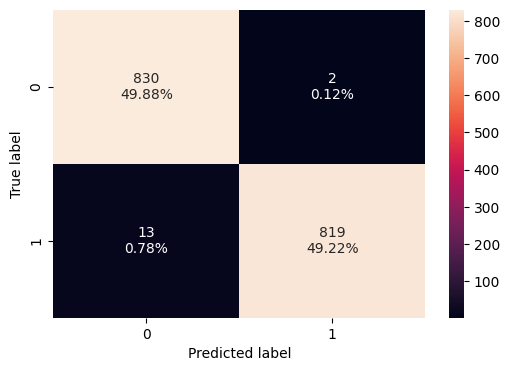

In [ ]:
# Confusion matrix for model 'tuned_gbm_undersamp' on training set:
confusion_matrix_sklearn(tuned_gbm_undersamp, X_train_un, y_train_un)

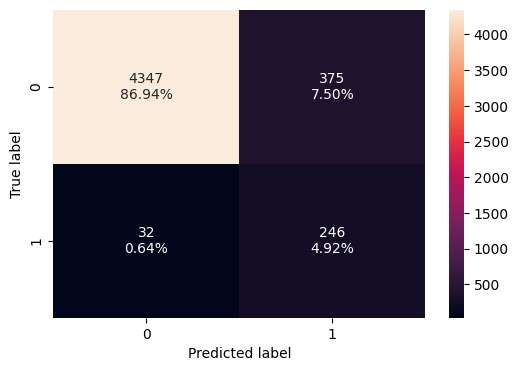

In [ ]:
# Confusion matrix for model 'tuned_gbm_undersamp' on validation set:
confusion_matrix_sklearn(tuned_gbm_undersamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_gbm_undersamp'
print (pd.DataFrame(tuned_gbm_undersamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V36 0.20262
V18 0.10264
V14 0.06173
V39 0.05816
V3  0.05789


Observations on Gradient Boosting model 'tuned_xgb_undersamp' :

*   The optimum values of hyperparameters after cross-validated random search are:
    *   max_features= 0.7
    *   learning_rate=0.2
    *   n_estimators=100
    *   subsample=0.5

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 99.10 | 91.86
Recall | 98.44 | 88.49
Precision | 99.76 | 39.61
F1-Score | 99.09 | 54.73

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.12 | 7.50
False Negative | 0.78 | 0.64

*   Since the recall of the model is around 98% on the train data and the recall of the model is 88.5% on the validation data, we can say that this model is overfitting the training data. Also, there is a huge difference between training and validation scores for other metrics (precision and F1 score).  Hence, this model will not generalize well on unseen data.

*   The top 5 most important features according to this model are V36, V18, V14, V39, and V3.

### AdaBoost with undersampled data

In [ ]:
# defining model
tuned_abc_undersamp = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200],
              "learning_rate": [0.2, 0.05],
               "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                  DecisionTreeClassifier(max_depth=2, random_state=1),
                                  DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_abc_undersamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 100, 'learning_rate': 0.05, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.8846114998917827:


In [ ]:
tuned_abc_undersamp = AdaBoostClassifier(
    n_estimators= 100,
    learning_rate= 0.05,
    base_estimator= DecisionTreeClassifier(max_depth=3,random_state=1),
    random_state= 1)

tuned_abc_undersamp.fit(X_train_un, y_train_un)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.05, n_estimators=100, random_state=1)

In [ ]:
model_tuned_abc_undersamp_train_perf=model_performance_classification_sklearn(tuned_abc_undersamp,X_train_un,y_train_un)
print("Training performance:")
model_tuned_abc_undersamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.96875 0.94351    0.99367 0.96794

In [ ]:
model_tuned_abc_undersamp_val_perf=model_performance_classification_sklearn(tuned_abc_undersamp,X_val,y_val)
print("Validation performance:")
model_tuned_abc_undersamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.92860 0.88849    0.43106 0.58049

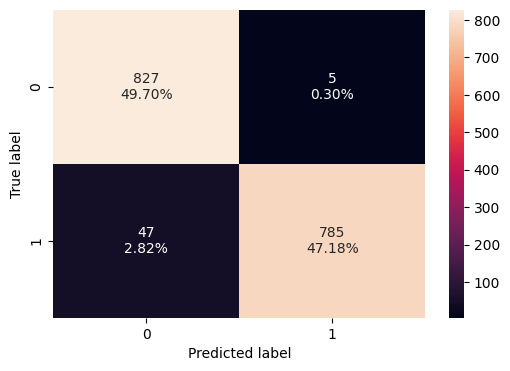

In [ ]:
# Confusion matrix for model 'tuned_abc_undersamp' on training set:
confusion_matrix_sklearn(tuned_abc_undersamp, X_train_un, y_train_un)

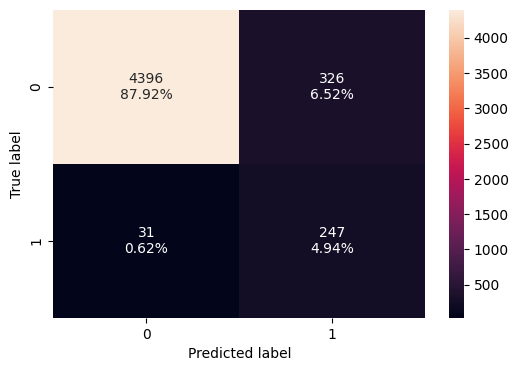

In [ ]:
# Confusion matrix for model 'tuned_abc_undersamp' on validation set:
confusion_matrix_sklearn(tuned_abc_undersamp, X_val, y_val)

In [ ]:
# Importance of features of model 'tuned_abc_undersamp'
print (pd.DataFrame(tuned_abc_undersamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V21 0.09158
V18 0.07650
V36 0.07207
V14 0.06048
V3  0.05479


Observations on AdaBoosting model 'tuned_abc_undersamp':

*   The optimum values of hyperparameters after cross-validated random search are:
    *   n_estimators= 100
    *   learning_rate= 0.05
    *   base_estimator= DecisionTreeClassifier(max_depth=3,random_state=1)

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 96.87 | 92.86
Recall | 94.35 | 88.85
Precision | 99.37 | 43.11
F1-Score | 96.79 | 58.05

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 0.30 | 6.52
False Negative | 2.82 | 0.62

*   Since the recall of the model is around 94% on the train data and the recall of the model is 88.85% on the validation data, we can say that this model is generalizing well on the validation data.

*   The top 5 most important features according to this model are V21, V18, V36, V14, and V3.

### Logistic Regression with undersampled data

In [ ]:
# defining model
tuned_lr_undersamp = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=tuned_lr_undersamp,
                                   param_distributions=param_grid,
                                   n_iter= 10,
                                   n_jobs = -1,
                                   scoring=scorer,
                                   cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8653560349181155:


In [ ]:
tuned_lr_undersamp = LogisticRegression(C= 0.1)
tuned_lr_undersamp.fit(X_train_un, y_train_un)

LogisticRegression(C=0.1)

In [ ]:
model_tuned_lr_undersamp_train_perf=model_performance_classification_sklearn(tuned_lr_undersamp,X_train_un,y_train_un)
print("Training performance:")
model_tuned_lr_undersamp_train_perf

Training performance:


Accuracy  Recall  Precision      F1
0   0.87320 0.87500    0.87186 0.87343

In [ ]:
model_tuned_lr_undersamp_val_perf=model_performance_classification_sklearn(tuned_lr_undersamp,X_val,y_val)
print("Validation performance:")
model_tuned_lr_undersamp_val_perf

Validation performance:


Accuracy  Recall  Precision      F1
0   0.85700 0.85252    0.26015 0.39865

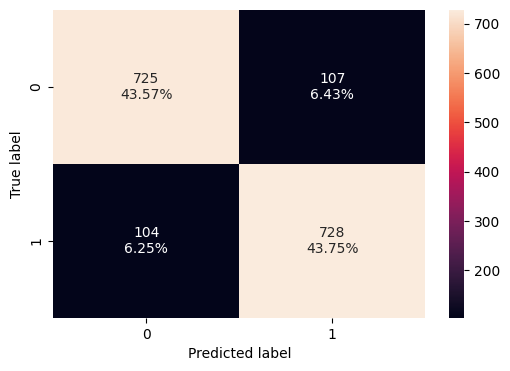

In [ ]:
# Confusion matrix for model 'tuned_lr_undersamp' on training set:
confusion_matrix_sklearn(tuned_lr_undersamp, X_train_un, y_train_un)

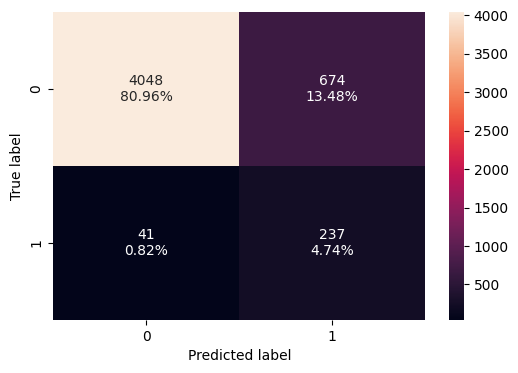

In [ ]:
# Confusion matrix for model 'tuned_lr_undersamp' on validation set:
confusion_matrix_sklearn(tuned_lr_undersamp, X_val, y_val)

Observations on Logistic Regression model, 'tuned_lr_undersamp':

*   The optimum values of hyperparameters after cross-validated random search are:
    *   C= 0.1

*   Below are the different metric scores on the training and validation datasets:

Metric | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
Accuracy | 87.32 |  85.70
Recall | 87.50 | 85.25
Precision | 87.19 | 26.01
F1-Score | 87.34 | 39.86

*   Below are the percentages of FP and FN identified by the model on the training and validation datasets:

Type | Training Dataset(%) | Validation Dataset(%)
-------|------------------|--------------
False Positive | 6.43 | 13.48
False Negative | 6.25 | 0.82

*   Since the recall of the model is around 87.50% on the train data and the recall of the model is 85.25% on the validation data, we can say that this model is generalizing well on the validation data.

*   However, the model does not generalize well in terms of precision and F1 scores as there is a huge gap in these metrics values in testing and validation sets.


## **Model performance comparison and choosing the final model**

In [ ]:
index_name= ['Hyperparameter Tuned Gradient Boost Model (Fitted using oversampled data)',
             'Hyperparameter Tuned AdaBoost Model (Fitted using oversampled data)',
             'Hyperparameter Tuned Logistic Regression Model (Fitted using oversampled data)',
             'Hyperparameter Tuned XGBoost Model (Fitted using undersampled data)',
             'Hyperparameter Tuned Random Forest Model (Fitted using undersampled data)',
             'Hyperparameter Tuned Gradient Boost Model (Fitted using undersampled data)',
             'Hyperparameter Tuned AdaBosst Model (Fitted using undersampled data)',
             'Hyperparameter Tuned Logistic Regression Model (Fitted using undersampled data)']

In [ ]:
model_name = ['tuned_gbm_oversamp',
              'tuned_abc_oversamp',
              'tuned_lr_oversamp',
              'tuned_xgb_undersamp',
              'tuned_rf_undersamp',
              'tuned_gbm_undersamp',
              'tuned_abc_undersamp',
              'tuned_lr_undersamp']

In [ ]:
train_perf_dfs = [model_tuned_gbm_oversamp_train_perf,
                  model_tuned_abc_oversamp_train_perf,
                  model_tuned_lr_oversamp_train_perf,
                  model_tuned_xgb_undersamp_train_perf,
                  model_tuned_rf_undersamp_train_perf,
                  model_tuned_gbm_undersamp_train_perf,
                  model_tuned_abc_undersamp_train_perf,
                  model_tuned_lr_undersamp_train_perf]

In [ ]:
validation_perf_dfs = [model_tuned_gbm_oversamp_val_perf,
                       model_tuned_abc_oversamp_val_perf,
                       model_tuned_lr_oversamp_val_perf,
                       model_tuned_xgb_undersamp_val_perf,
                       model_tuned_rf_undersamp_val_perf,
                       model_tuned_gbm_undersamp_val_perf,
                       model_tuned_abc_undersamp_val_perf,
                       model_tuned_lr_undersamp_val_perf]


In [ ]:
# Training Dataset metrics
acc_train = [x['Accuracy'][0] for x in train_perf_dfs]
recall_train = [x['Recall'][0] for x in train_perf_dfs]
precision_train = [x['Precision'][0] for x in train_perf_dfs]
f1_train = [x['F1'][0] for x in train_perf_dfs]

In [ ]:
# Validation dataset metrics
acc_val = [x['Accuracy'][0] for x in validation_perf_dfs]
recall_val = [x['Recall'][0] for x in validation_perf_dfs]
precision_val = [x['Precision'][0] for x in validation_perf_dfs]
f1_val = [x['F1'][0] for x in validation_perf_dfs]

In [ ]:
# Creating dataframe containing performance metrics for both training and testing data:
performance_df = pd.DataFrame()
performance_df['model_name'] = model_name
performance_df.index = index_name
performance_df['Training Data Accuracy'] = acc_train
performance_df['Validation Data Accuracy'] = acc_val
performance_df['Training Data Recall'] = recall_train
performance_df['Validation Data Recall'] = recall_val
performance_df['Training Data Precision'] = precision_train
performance_df['Validation Data Precision'] = precision_val
performance_df['Training Data F1 score'] = f1_train
performance_df['Validation Data F1 score'] = f1_val

In [ ]:
performance_df

model_name  \
Hyperparameter Tuned Gradient Boost Model (Fitt...   tuned_gbm_oversamp   
Hyperparameter Tuned AdaBoost Model (Fitted usi...   tuned_abc_oversamp   
Hyperparameter Tuned Logistic Regression Model ...    tuned_lr_oversamp   
Hyperparameter Tuned XGBoost Model (Fitted usin...  tuned_xgb_undersamp   
Hyperparameter Tuned Random Forest Model (Fitte...   tuned_rf_undersamp   
Hyperparameter Tuned Gradient Boost Model (Fitt...  tuned_gbm_undersamp   
Hyperparameter Tuned AdaBosst Model (Fitted usi...  tuned_abc_undersamp   
Hyperparameter Tuned Logistic Regression Model ...   tuned_lr_undersamp   

                                                    Training Data Accuracy  \
Hyperparameter Tuned Gradient Boost Model (Fitt...                 0.99340   
Hyperparameter Tuned AdaBoost Model (Fitted usi...                 0.99178   
Hyperparameter Tuned Logistic Regression Model ...                 0.88036   
Hyperparameter Tuned XGBoost Model (Fitted usin...                 0.99038   
Hyperparameter Tuned Random Forest Model (Fitte...                 0.98798   
Hyperparameter Tuned Gradient Boost Model (Fitt...                 0.99099   
Hyperparameter Tuned AdaBosst Model (Fitted usi...                 0.96875   
Hyperparameter Tuned Logistic Regression Model ...                 0.87320   

                                                    Validation Data Accuracy  \
Hyperparameter Tuned Gradient Boost Model (Fitt...                   0.96940   
Hyperparameter Tuned AdaBoost Model (Fitted usi...                   0.97920   
Hyperparameter Tuned Logistic Regression Model ...                   0.86840   
Hyperparameter Tuned XGBoost Model (Fitted usin...                   0.86260   
Hyperparameter Tuned Random Forest Model (Fitte...                   0.94360   
Hyperparameter Tuned Gradient Boost Model (Fitt...                   0.91860   
Hyperparameter Tuned AdaBosst Model (Fitted usi...                   0.92860   
Hyperparameter Tuned Logistic Regression Model ...                   0.85700   

                                                    Training Data Recall  \
Hyperparameter Tuned Gradient Boost Model (Fitt...               0.99238   
Hyperparameter Tuned AdaBoost Model (Fitted usi...               0.98828   
Hyperparameter Tuned Logistic Regression Model ...               0.88396   
Hyperparameter Tuned XGBoost Model (Fitted usin...               1.00000   
Hyperparameter Tuned Random Forest Model (Fitte...               0.97716   
Hyperparameter Tuned Gradient Boost Model (Fitt...               0.98438   
Hyperparameter Tuned AdaBosst Model (Fitted usi...               0.94351   
Hyperparameter Tuned Logistic Regression Model ...               0.87500   

                                                    Validation Data Recall  \
Hyperparameter Tuned Gradient Boost Model (Fitt...                 0.85612   
Hyperparameter Tuned AdaBoost Model (Fitted usi...                 0.85252   
Hyperparameter Tuned Logistic Regression Model ...                 0.84892   
Hyperparameter Tuned XGBoost Model (Fitted usin...                 0.91007   
Hyperparameter Tuned Random Forest Model (Fitte...                 0.88489   
Hyperparameter Tuned Gradient Boost Model (Fitt...                 0.88489   
Hyperparameter Tuned AdaBosst Model (Fitted usi...                 0.88849   
Hyperparameter Tuned Logistic Regression Model ...                 0.85252   

                                                    Training Data Precision  \
Hyperparameter Tuned Gradient Boost Model (Fitt...                  0.99441   
Hyperparameter Tuned AdaBoost Model (Fitted usi...                  0.99524   
Hyperparameter Tuned Logistic Regression Model ...                  0.87765   
Hyperparameter Tuned XGBoost Model (Fitted usin...                  0.98113   
Hyperparameter Tuned Random Forest Model (Fitte...                  0.99877   
Hyperparameter Tuned Gradient Boost Model (Fitt...                  0.99756   
Hyperparameter Tuned

Observation:

*   Hypertuned AdaBoost model on undersampled data has given a generalized performance with the highest recall on validation data, so we will consider it as our final model.
*   Since recall is the metric to be maximized, hence, we have used recall as the scoring metric. Hence, other metrics such as precision and recall are suffering in the models. However, among the models created above, 'tuned_abc_undersamp' has the best precision and F1- scores.   



### Test set final performance

In [ ]:
# Calculating different metrics on the test set
model_tuned_abc_undersamp_test_perf = model_performance_classification_sklearn(tuned_abc_undersamp, X_test, y_test)
print("Test performance:")
model_tuned_abc_undersamp_test_perf

Test performance:


Accuracy  Recall  Precision      F1
0   0.93440 0.85461    0.45644 0.59506

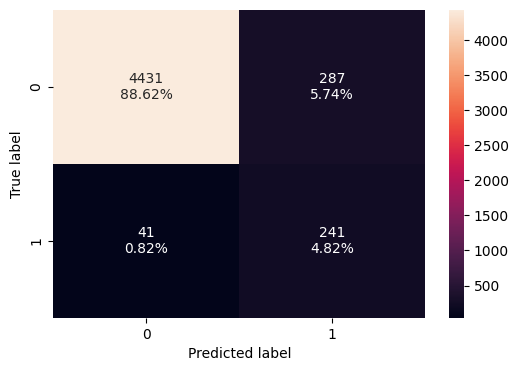

In [ ]:
# Confusion matrix for model 'tuned_abc_undersamp' on test set:
confusion_matrix_sklearn(tuned_abc_undersamp, X_test, y_test)

In [ ]:
# Importance of features of model 'tuned_abc_undersamp'
print (pd.DataFrame(tuned_abc_undersamp.feature_importances_, columns = ["Imp"],
                    index = X_train.columns).sort_values(by = 'Imp', ascending = False).head())

        Imp
V21 0.09158
V18 0.07650
V36 0.07207
V14 0.06048
V3  0.05479


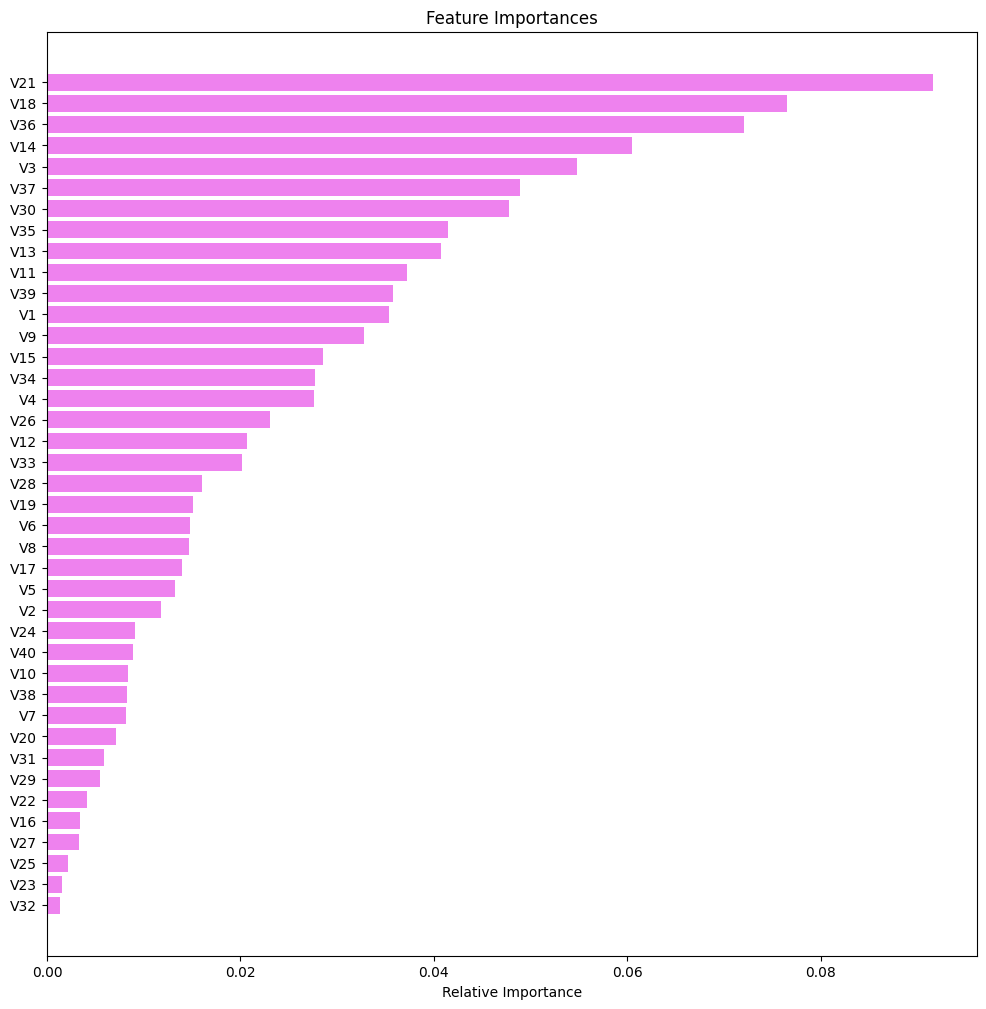

In [ ]:
# Plot for showing the importances of different features in predicting failure/no failure in the system:
feature_names = X.columns
importances = tuned_abc_undersamp.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Observations:

*   Below are the different metric scores on the training, validation and testing datasets:

Metric | Training Dataset(%) | Validation Dataset(%) | Testing Dataset (%)
-------|------------------|--------------|----------
Accuracy | 96.87 | 92.86 | 93.44
Recall | 94.35 | 88.85 | 85.46
Precision | 99.37 | 43.11 | 45.64
F1-Score | 96.79 | 58.05 | 59.51

*   Below are the percentages of FP and FN identified by the model on the training, validation and testing datasets:

Type | Training Dataset(%) | Validation Dataset(%) | Testing Dataset (%)
-------|------------------|--------------|------------
False Positive | 0.30 | 6.52 | 5.74
False Negative | 2.82 | 0.62 | 0.82

*   The model has given generalized performance on the test set.

*   The top 5 most important features according to this model are V21, V18, V36, V14, and V3.

Checking how the top 5 important features affect the target classes in the train dataset

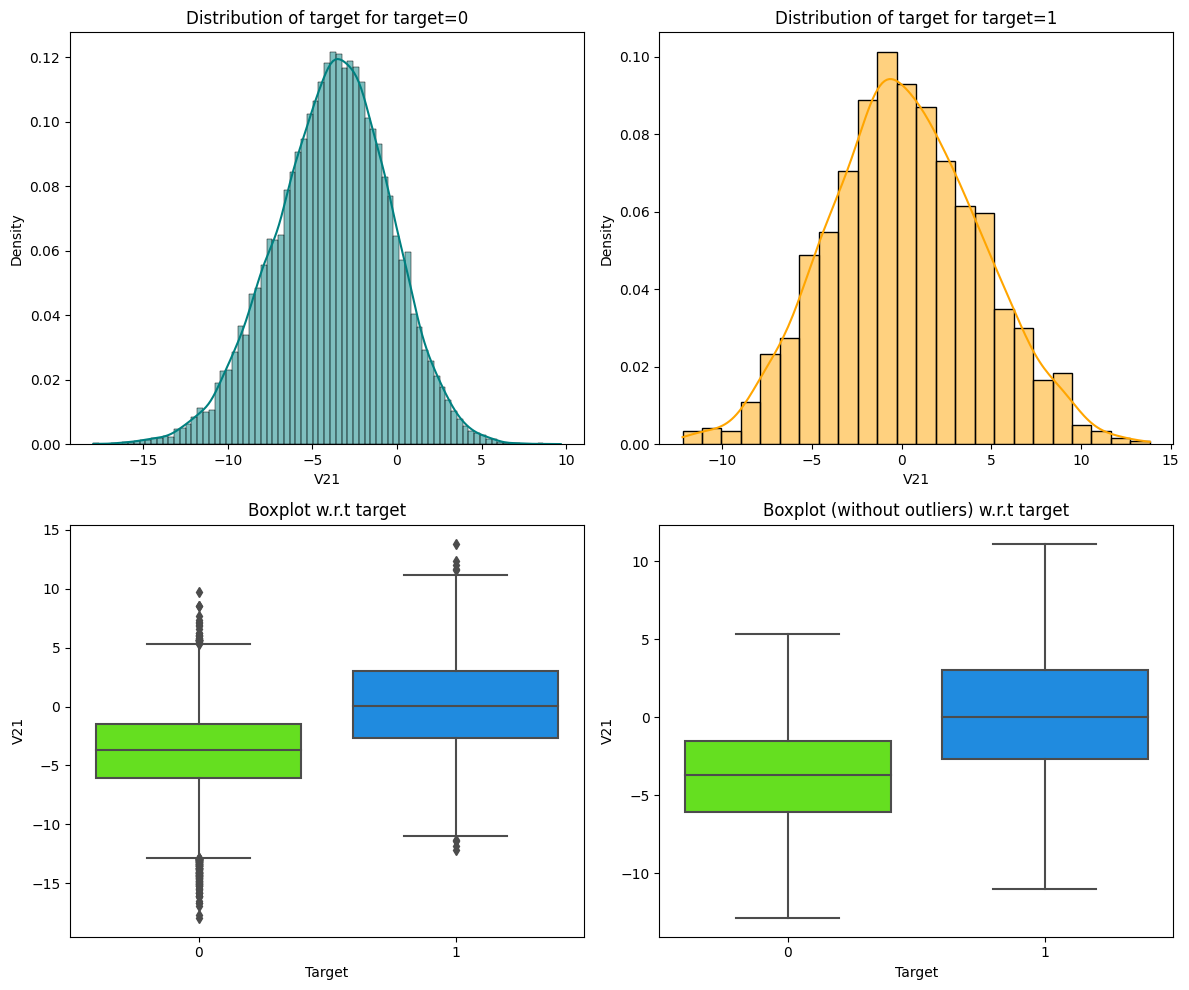

In [ ]:
distribution_plot_wrt_target(df, 'V21', 'Target')

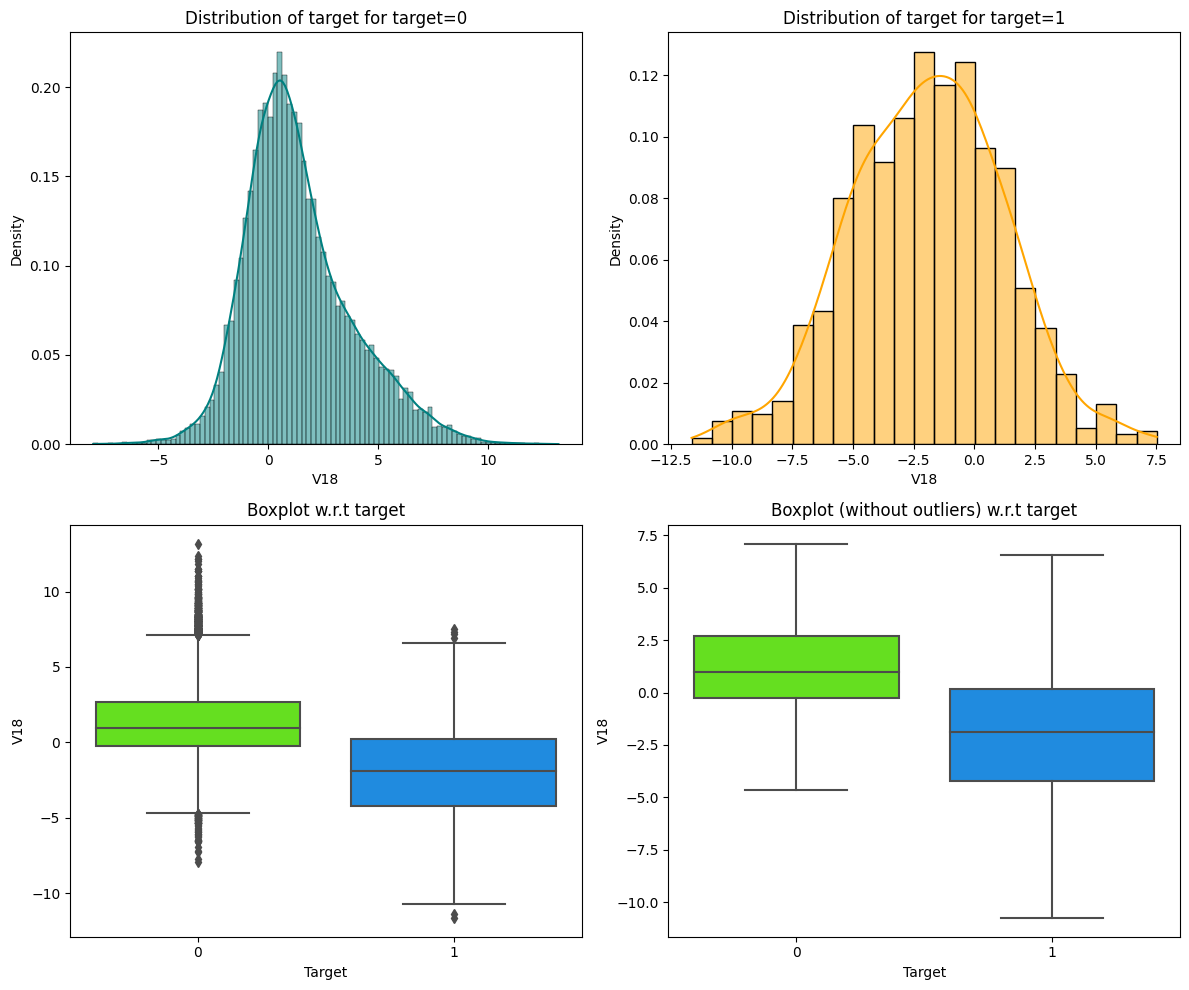

In [ ]:
distribution_plot_wrt_target(df, 'V18', 'Target')

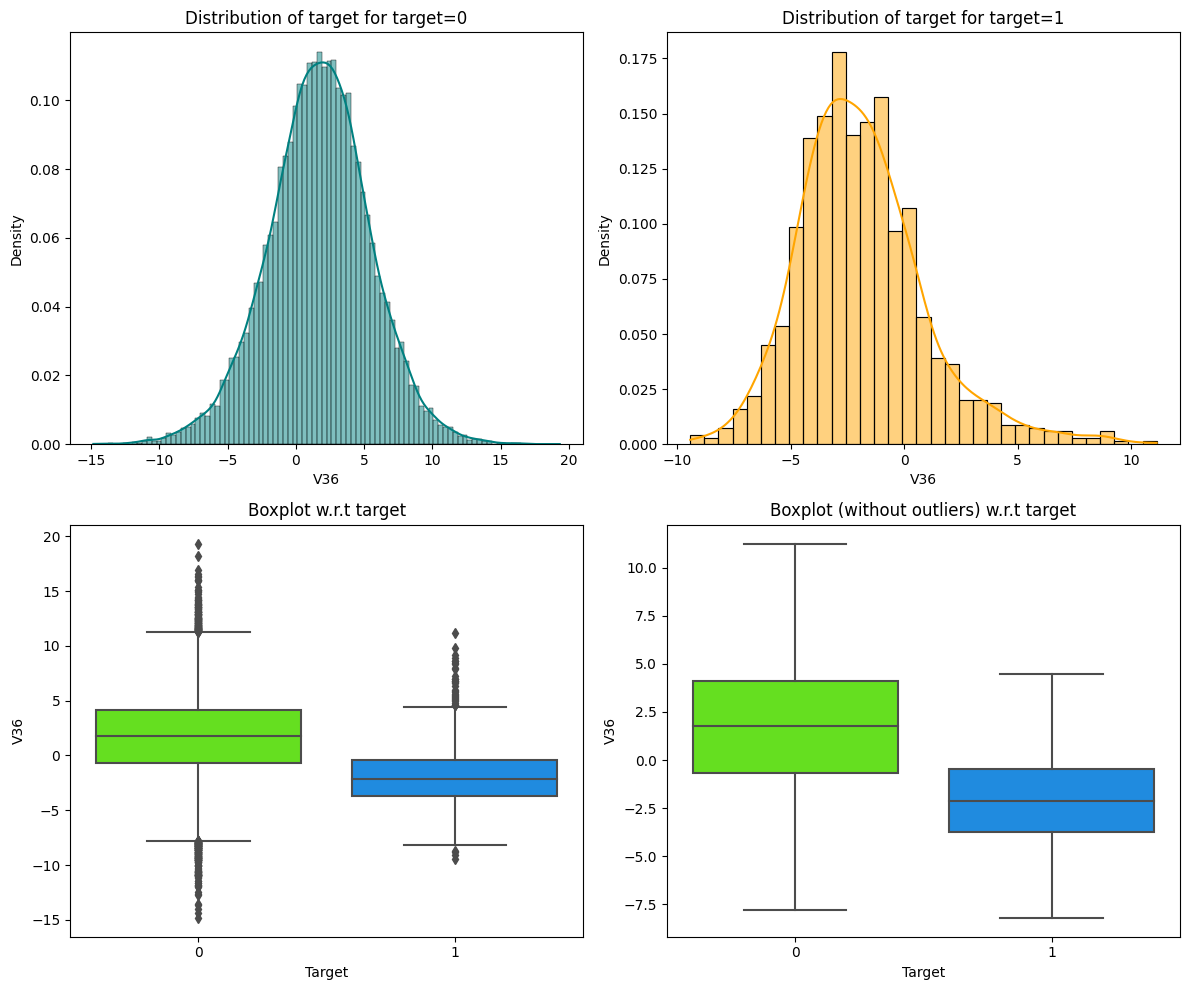

In [ ]:
distribution_plot_wrt_target(df, 'V36', 'Target')

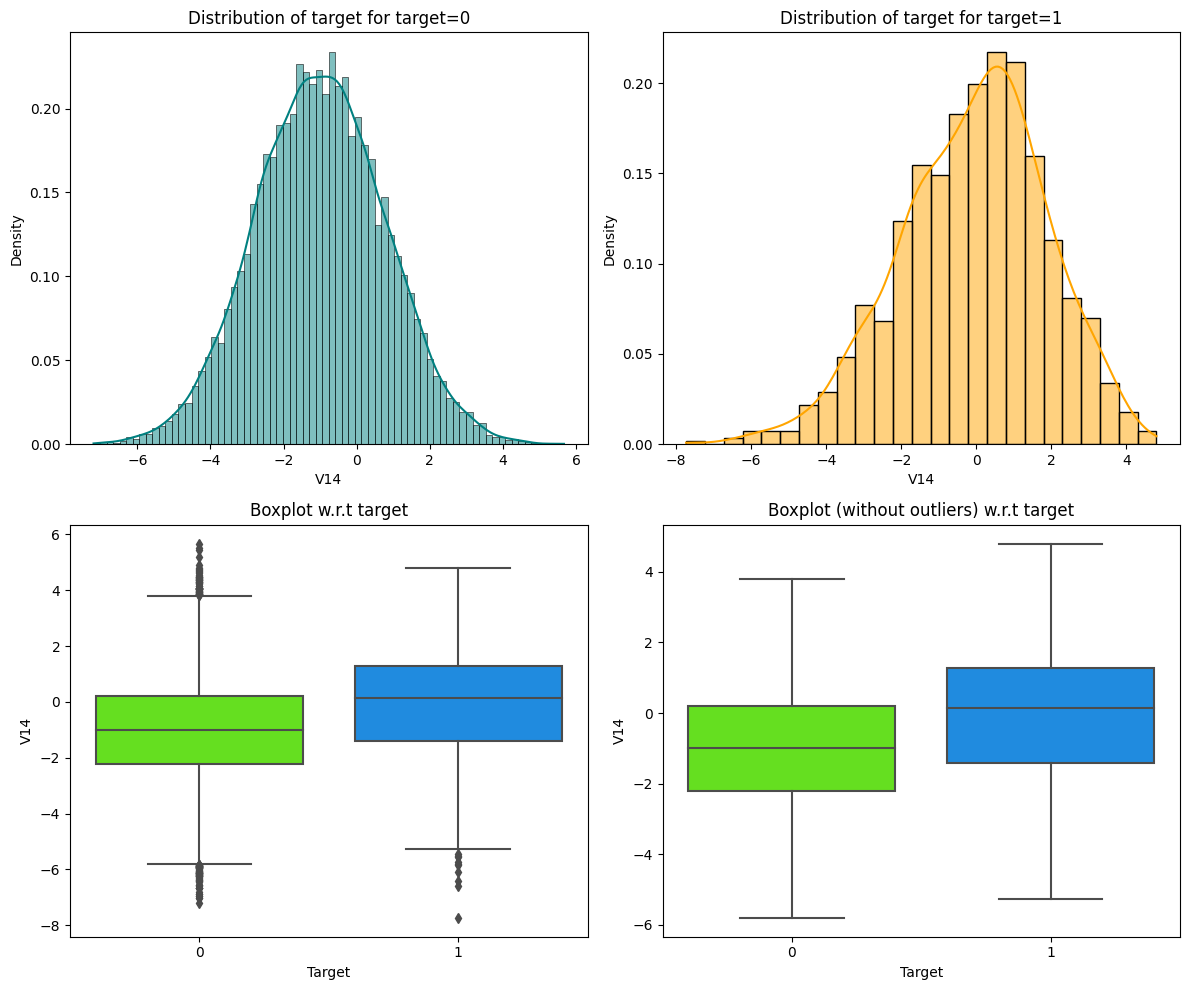

In [ ]:
distribution_plot_wrt_target(df, 'V14', 'Target')

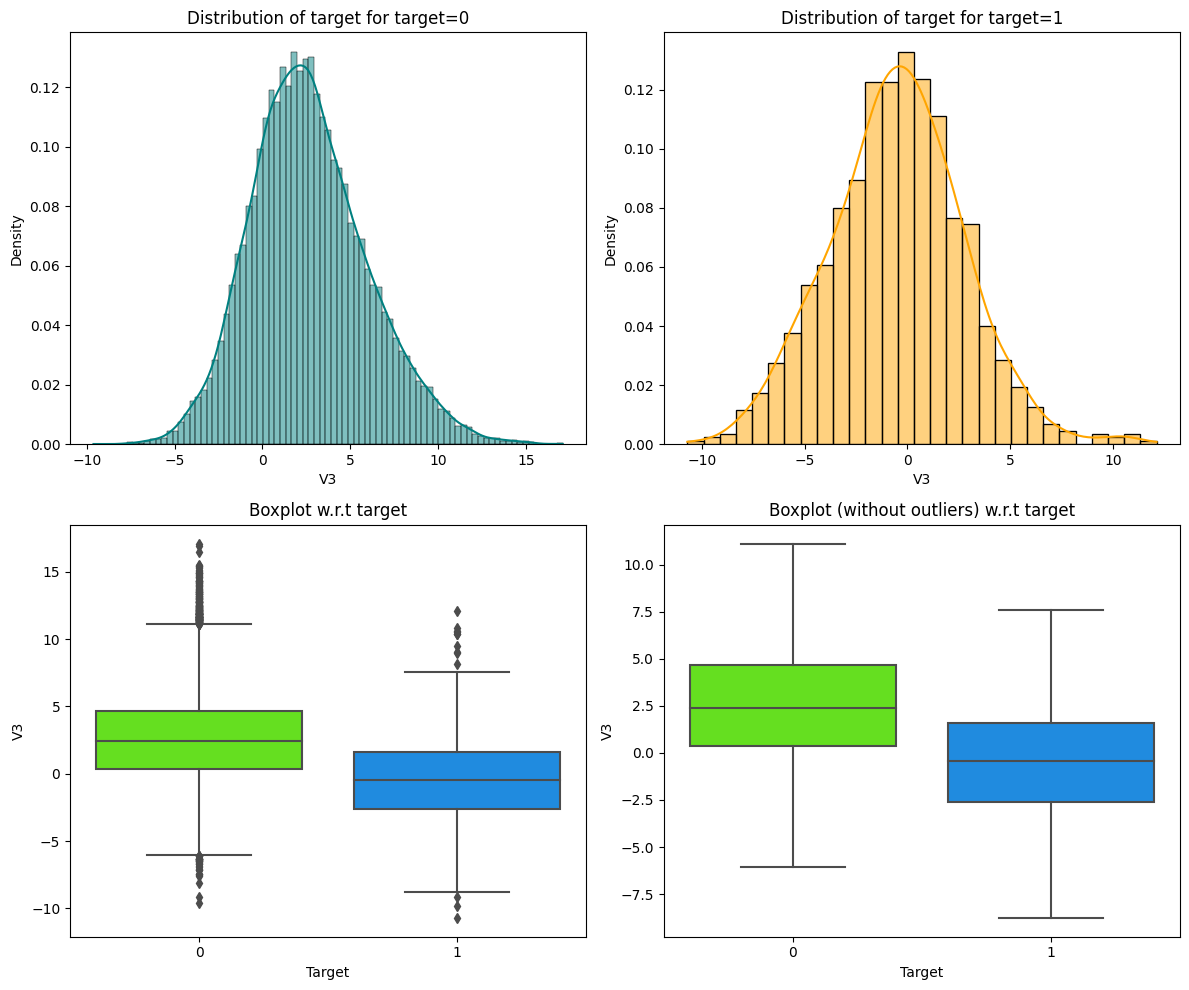

In [ ]:
distribution_plot_wrt_target(df, 'V3', 'Target')

Observations:

*   The average and median values of the feature 'V21' is higher when there is a failure in the machine/system as compared to a no-failure scenario (as shown below). This implies that higher values of 'V21' increase the chances of system failure.

Target class| Average Value | Median Value
-|-|-
1 | 0.16245 | 0.01215
0 | -3.83300 | -3.68392

*   The average and median values of the feature 'V18' is lower when there is a failure in the machine/system as compared to a no-failure scenario (as shown below). This implies that lower values of 'V18' increase the chances of system failure.

Target class| Average Value | Median Value
-|-|-
1 | -1.94752 | -1.87314
0 | 1.37367 | 0.97783

*   The average and median values of the feature 'V36' is lower when there is a failure in the machine/system as compared to a no-failure scenario (as shown below). This implies that lower values of 'V36' increase the chances of system failure.

Target class| Average Value | Median Value
-|-|-
1 | -1.87902 | -2.11812
0 | 1.71423 | 1.76754

*   The average and median values of the feature 'V14' is higher when there is a failure in the machine/system as compared to a no-failure scenario (as shown below). This implies that higher values of 'V14' increase the chances of system failure.

Target class| Average Value | Median Value
-|-|-
1 | -0.08254 | 0.13511
0 | -1.00164 | -1.00195


*   The average and median values of the feature 'V3' is lower when there is a failure in the machine/system as compared to a no-failure scenario (as shown below). This implies that lower values of 'V3' increase the chances of system failure.

Target class| Average Value | Median Value
-|-|-
1 | -0.50502 | -0.42923
0 | 2.66038 | 2.40466

*   Obserations for all the other columns can be made similarly.


## **Pipelines to build the final model**


In [ ]:
# creating a list of numerical variables
numerical_features = ['V1','V2','V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                      'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                      'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
                      'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40']

# Creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

In [ ]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_features)],
                                 remainder="passthrough")

In [ ]:
# Creating model pipeline with best parameters:
model = Pipeline(steps=[("pre", preprocessor),("ABC",AdaBoostClassifier(n_estimators= 100,
                                                                        learning_rate= 0.05,
                                                                        base_estimator= DecisionTreeClassifier(max_depth=3,random_state=1),
                                                                        random_state= 1))])

In [ ]:
# Separating target variable and other variables:
X_train = df.drop(["Target"], axis=1)
y_train = df["Target"]

X_test = df_test.drop(["Target"], axis=1)
y_test = df_test["Target"]

In [ ]:
# Inputing training dataset features as undersampling the data cannot be done without doing missing value treatment:
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [ ]:
# Undersampling the train dataset as the chosen model works best on undersampled data:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
# Fitting the model on undersampled training data:
model.fit(X_train_un, y_train_un)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...])])),
                ('ABC',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.05, n_estimators=100,
                                    random_state=1))])

In [ ]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Checking performance on train dataset:
model_train_perf = model_performance_classification_sklearn(model, X_train_un, y_train_un)
model_train_perf

Accuracy  Recall  Precision      F1
0   0.95270 0.91351    0.99120 0.95077

In [ ]:
# Checking performance on test dataset:
model_test_perf = model_performance_classification_sklearn(model, X_test, y_test)
model_test_perf

Accuracy  Recall  Precision      F1
0   0.93340 0.85106    0.45198 0.59041

Observations:

*   The best algorithm for the prediction of a failure in the machine/system is a hyperparameter-tuned AdaBoost model. Undersampling has been able to reduce the imbalance between the target classes.

*   The optimum values of hyperparameters after cross-validated random search are:
    *   n_estimators= 100
    *   learning_rate= 0.05
    *   base_estimator= DecisionTreeClassifier(max_depth=3,random_state=1)

*   Below are the different metric scores of the final model on the training and test datasets:

Metric | Training Dataset(%) | Test Dataset(%)
-------|------------------|--------------
Accuracy | 95.27 | 93.34
Recall | 91.35 | 85.11
Precision | 99.12 | 45.20
F1-Score | 95.08  | 59.04

*   Since the recall score of the model is around 91% on the train data and 85.11% on the test data, we can say that the model is performing well on the test data in terms of recall and will generalize on unseen data.


## **Business Insights and Conclusions**

*   The best algorithm for the prediction of a failure in the machine/system is a hyperparameter-tuned AdaBoost model. Undersampling also has been to reduce the imbalance between the target classes.

*   The optimum values of hyperparameters after cross-validated random search are:
    *   n_estimators= 100
    *   learning_rate= 0.05
    *   base_estimator= DecisionTreeClassifier(max_depth=3,random_state=1)

*   Below are the different metric scores of the final model on the training and test datasets:

Metric | Training Dataset(%) | Test Dataset(%)
-------|------------------|--------------
Accuracy | 95.27 | 93.34
Recall | 91.35 | 85.11
Precision | 99.12 | 45.20
F1-Score | 95.08  | 59.04

*   Since the recall score of the model is around 91% on the train data and 85.11% on the test data, we can say that the model is performing well on the test data in terms of recall and will generalize on unseen data.

*   The top 5 most important features according to this model are V21, V18, V36, V14, and V3.

*   Following are the insights on the important features :
    *   With higher values of 'V21', the chances of system failure increase.
    *   With lower values of 'V18', the chances of system failure increase.
    *   With lower values of 'V36', the chances of system failure increase.
    *   With higher values of 'V14', the chances of system failure increase.
    *   With lower values of 'V3', the chances of system failure increases.



***